# **Problem Formulation**
**Objective:**

To predict the variable
N (Number of Taps) at London Underground stations using machine learning models, with a specific focus on the XGBoost Regressor, and to evaluate the performance of these models for time-series forecasting.


**Background:**

There are a number of factors that affect the volume of taps or exits from each station in London Underground's complex transit system.Understanding these patterns is crucial for optimizing station management and public transportation planning.  To make a complete view of the system, this data set is composed of several aspects that include lockdown periods, station attributes and time series.

## **Dataset:**

The dataset, derived from Transport for London's Oyster and Contactless ticketing databases, is a detailed record of tube station interactions. It records daily arrivals and exits at each tube station in 15-minute intervals from January 1, 2020 through April 30, 2021. It tracks the commencement and duration of national and regional lockdowns, as well as mandatory closures of non-essential retail, pubs/restaurants, and schools.The dataset provides a detailed overview of numerous attributes, from everyday activities and lockdown regulations to information about train terminals.

### **MACHINE LEARNING PIPELINE**
Data Preprocessing: Handling missing values, encode categorical variables, and perform feature scaling.

Feature Engineering: Creating lag features for 7 days, 14-days, 21 days.

Model Selection: Using XGBoost Regressor as the primary model, and compare its performance with other machine learning models like Random Forest, Linear Regression, and SVM.

Training and Validation: Splitting the dataset into training, validation, and test sets considering the time-series nature of the data. Use metrics like RMSE, MAE, and R-squared for evaluation.

Hyperparameter Tuning: Optimize model parameters using techniques like Random Search.

Evaluation: Assess model performance on the test set and compare the results across different models.

In [60]:
import pandas as pd
import pickle
import json
import numpy as np
import seaborn as sns
from math import ceil
import pickle
import warnings
warnings.filterwarnings("ignore")
from random import seed
from random import randrange
from csv import reader
from math import sqrt
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from sklearn.metrics import r2_score
import os
from collections import Counter
import string
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
import datetime

#### **Features Description:**

1.   <small>
CALENDARDATE: A character field representing the date of the event, formatted as '%d/%m/%Y'.
</small>
2.   <small>DOW: A character field indicating the Day of the Week.</small>

1.  <small> NLC: An integer field for the National Location Code, with values ranging from 500 to 6960.
</small>

1.   <small>SUBSYSTEM: A character field identifying the subsystem of rail taps received, set to 'LU' for London Underground.</small>

1.    <small>HOUR: A numeric field denoting the quarter-hour of the day, expressed as a decimal (e.g., 9.25 represents the period from 0915 to 0930 hrs)</small>

1.    <small>ENTRYEXIT: A character field indicating the direction of travel through the gateline, either 'ENTRY' for in or 'EXIT' for out.</small>
2.    <small>N: An integer field representing the number of taps during the 15-minute period.</small>


2.    <small>LOCKDOWN_NATIONAL and LOCKDOWN_REGIONAL: Indicate the status of national and regional lockdowns, respectively.</small>


2.    <small>SHOPS_CLOSED, PUBS_CLOSED, and SCHOOLS_CLOSED: Represent the closure status of various public establishments.</small>

2.    <small>NLC: An integer field indicating the National Location Code for each station.</small>

1.    <small>STATIONNAME: A character field providing the name of the station.</small>

1.    <small>MODE: A character field set to 'LU,' indicating the dataset is specific to the London Underground.</small>

1.     <small>BOROUGH: A character field specifying the borough, typically within the Greater London Area, where the station is located.</small>
2.    <small>STATIONTYPE: A character field classifying stations into various types like Shopping, City, Termini, and Inner/Outer Suburb.</small>

2.     <small>NAPTAN: A character field used as an alternative reference for the station, often used in TfL's Journey Planner API.</small>

2.     <small>QHR: A numeric field that represents the specific fifteen-minute interval of interest. This column sometimes aligns with the "HOUR" field in other related datasets.</small>

1. <small>PERIOD: A character field that identifies which three-hour block the given QHR falls into, with considerations for AM and PM peak periods, particularly valid on weekdays.</small>
2.  <small>The dataset enriches National Location Codes (NLC) with spatial and fare zone information for tube stations. It includes X and Y coordinates in a specialized system, a three-letter station code, fare zone, and geographical latitude and longitude.</small>


In [62]:
merge_data= pd.read_csv('./tfl_merge_cpldata.csv')

In [33]:
merge_data.head()

,CALENDARDATE,DOW,NLC,SUBSYSTEM,HOUR,ENTRYEXIT,N,CODE,ZONE,LAT,...,LOCKDOWN_REGIONAL,SHOPS_CLOSED,PUBS_CLOSED,SCHOOLS_CLOSED,STATIONNAME,MODE,BOROUGH,STATIONTYPE,NAPTAN,PERIOD
0,2020-02-02,SUN,501,LU,6.75,Entry,10,BAR,1.0,51.5202,...,0,0,0,0,Barbican,LU,City of London,City,940GZZLUBBN,EM (0400-0700)
1,2020-02-02,SUN,501,LU,6.75,Exit,17,BAR,1.0,51.5202,...,0,0,0,0,Barbican,LU,City of London,City,940GZZLUBBN,EM (0400-0700)
2,2020-02-02,SUN,501,LU,7.00,Entry,16,BAR,1.0,51.5202,...,0,0,0,0,Barbican,LU,City of London,City,940GZZLUBBN,AM (0700-1000)
3,2020-02-02,SUN,501,LU,7.00,Exit,12,BAR,1.0,51.5202,...,0,0,0,0,Barbican,LU,City of London,City,940GZZLUBBN,AM (0700-1000)
4,2020-02-02,SUN,501,LU,7.25,Entry,13,BAR,1.0,51.5202,...,0,0,0,0,Barbican,LU,City of London,City,940GZZLUBBN,AM (0700-1000)


In [34]:
merge_data.isnull().any()

CALENDARDATE         False
DOW                  False
NLC                  False
SUBSYSTEM            False
HOUR                 False
ENTRYEXIT            False
N                    False
CODE                 False
ZONE                 False
LAT                  False
LONG                 False
LOCKDOWN_NATIONAL    False
LOCKDOWN_REGIONAL    False
SHOPS_CLOSED         False
PUBS_CLOSED          False
SCHOOLS_CLOSED       False
STATIONNAME          False
MODE                 False
BOROUGH              False
STATIONTYPE          False
NAPTAN               False
PERIOD               False
dtype: bool

In [165]:
data=merge_data.copy()

In [36]:
# del merge_data

In [81]:
data['LOCKDOWN_REGIONAL'] = data['LOCKDOWN_REGIONAL'].astype(str)

In [220]:
# Convert CALENDARDATE column to datetime type
merge_data['CALENDARDATE'] = pd.to_datetime(merge_data['CALENDARDATE'])

# Extract year and month names
merge_data['YEAR'] = merge_data['CALENDARDATE'].dt.year
merge_data['MONTH'] = merge_data['CALENDARDATE'].dt.strftime('%b%y')

# Calculate the average transaction for each month
monthly_avg_hypothetical = merge_data.groupby(['YEAR', 'MONTH'])['N'].sum()

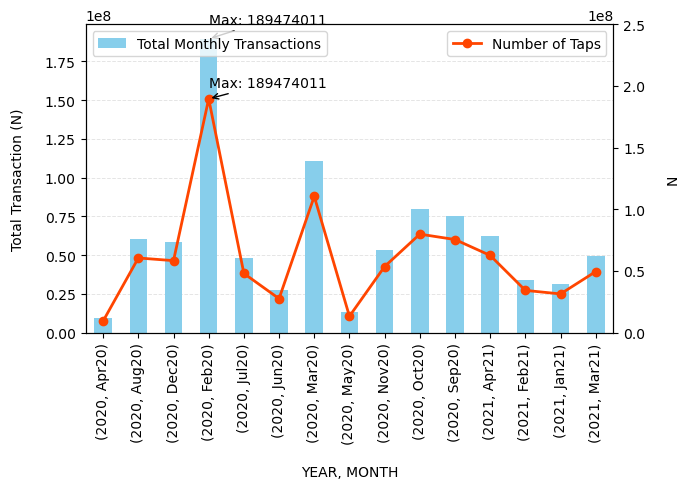

In [231]:
# Define colors and style for the plot
bar_color = '#A9A9A9'  # Gray color for bars
line_color = '#FF4500'  # Red color for the line
background_color = '#FFFFFF'  # White background
grid_color = '#D3D3D3'  # Light gray gridlines

# Plot the total transaction for each month with a red line representing the number of taps
plt.figure(figsize=(7, 5), facecolor=background_color)
ax = plt.gca()
ax.set_facecolor(background_color)

# Bar plot for total transactions
monthly_avg_hypothetical.plot(kind='bar', color='skyblue', label='Total Monthly Transactions', ax=ax)

# Line plot for number of taps
ax2 = ax.twinx()
monthly_avg_hypothetical.plot(kind='line', color=line_color, marker='o', label='Number of Taps', linewidth=2, ax=ax2)

# Get the coordinates for the point with the highest transaction value
highest_transaction_value = monthly_avg_hypothetical.max()
highest_transaction_index = monthly_avg_hypothetical.idxmax()
highest_transaction_plot_index = monthly_avg_hypothetical.index.get_loc(highest_transaction_index)

# Annotate the highest point on the graph for the bar plot
ax.annotate(f"Max: {highest_transaction_value}", 
            xy=(highest_transaction_plot_index, highest_transaction_value), 
            xytext=(highest_transaction_plot_index, highest_transaction_value + 0.05 * highest_transaction_value),
            arrowprops=dict(facecolor='black', arrowstyle='->'))

# Annotate the highest point on the graph for the line plot
ax2.annotate(f"Max: {highest_transaction_value}", 
             xy=(highest_transaction_plot_index, highest_transaction_value), 
             xytext=(highest_transaction_plot_index, highest_transaction_value + 0.05 * highest_transaction_value),
             arrowprops=dict(facecolor='red', arrowstyle='->'))

# Set labels, legends, and gridlines
# ax.set_title('Monthly Variations: Total Transactions vs. Number of Taps', fontsize=16, pad=20)
ax.set_xlabel('YEAR, MONTH', labelpad=15)
ax.set_ylabel('Total Transaction (N)', labelpad=15)
ax2.set_ylabel('N', labelpad=15)
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
ax.grid(axis='y', color=grid_color, linestyle='--', linewidth=0.7, alpha=0.6)
ax.set_axisbelow(True)
plt.ylim(0, 250000000)
plt.tight_layout()
plt.savefig('./Monthly Variations Total Transactions vs. Number of Taps.PNG',  bbox_inches='tight', dpi=300)
plt.show()

# Period weekdays

In [166]:
data.DOW.value_counts()

WED    2545766
TUE    2541172
THU    2538808
MON    2528580
FRI    2490464
SAT    2386870
SUN    2222998
Name: DOW, dtype: int64

In [112]:
# Filtering data for Weekdays (Monday to Friday)
df_weekdays = data[data['DOW'].isin(['MON', 'TUE', 'WED', 'THU', 'FRI'])]

In [120]:
# Group by 'CALENDARDATE' and 'STATIONTYPE' to get the sum of 'N' for each combination
aggregated_WEEKDAYS = df_weekdays.groupby(['CALENDARDATE','DOW', 'LOCKDOWN_REGIONAL','PERIOD'])['N'].sum().reset_index()

aggregated_WEEKDAYS.head(10)

,CALENDARDATE,DOW,LOCKDOWN_REGIONAL,PERIOD,N
0,2020-02-03,MON,0,AM (0700-1000),2030918
1,2020-02-03,MON,0,EM (0400-0700),285535
2,2020-02-03,MON,0,EV (1900-2200),889466
3,2020-02-03,MON,0,IP1 (1000-1300),880120
4,2020-02-03,MON,0,IP2 (1300-1600),979134
5,2020-02-03,MON,0,NT1 (2200-0100),271273
6,2020-02-03,MON,0,NT2 (0100-0400),960
7,2020-02-03,MON,0,PM (1600-1900),2132749
8,2020-02-04,TUE,0,AM (0700-1000),2152224
9,2020-02-04,TUE,0,EM (0400-0700),295061


In [125]:
avg_weekdays_lockdowntaps = aggregated_WEEKDAYS[aggregated_WEEKDAYS['LOCKDOWN_REGIONAL'] == '1']

In [126]:
avg_weekdays_lockdowntaps

,CALENDARDATE,DOW,LOCKDOWN_REGIONAL,PERIOD,N
280,2020-03-23,MON,1,AM (0700-1000),302217
281,2020-03-23,MON,1,EM (0400-0700),121758
282,2020-03-23,MON,1,EV (1900-2200),101243
283,2020-03-23,MON,1,IP1 (1000-1300),121943
284,2020-03-23,MON,1,IP2 (1300-1600),160956
...,...,...,...,...,...
2480,2021-04-12,MON,1,IP1 (1000-1300),348002
2481,2021-04-12,MON,1,IP2 (1300-1600),431811
2482,2021-04-12,MON,1,NT1 (2200-0100),94321
2483,2021-04-12,MON,1,NT2 (0100-0400),530


In [150]:
# Group by 'LOCKDOWN_NATIONAL' and 'STATIONTYPE' to compute the average taps during a lockdown for each station type
avg_weekdays_lockdowntaps = aggregated_WEEKDAYS[aggregated_WEEKDAYS['LOCKDOWN_REGIONAL'] == '1'].groupby(['LOCKDOWN_REGIONAL','PERIOD'])['N'].mean().reset_index()

# Rename the 'N' column to 'Average_Taps'
avg_weekdays_lockdowntaps.columns = ['LOCKDOWN_REGIONAL','PERIOD', 'AVERRAGE(N)']

avg_weekdays_lockdowntaps

,LOCKDOWN_REGIONAL,PERIOD,AVERRAGE(N)
0,1,AM (0700-1000),315382.112903
1,1,EM (0400-0700),102404.161290
2,1,EV (1900-2200),122971.491935
3,1,IP1 (1000-1300),152242.830645
4,1,IP2 (1300-1600),210441.653226
5,1,NT1 (2200-0100),33202.596774
6,1,NT2 (0100-0400),303.290323
7,1,PM (1600-1900),350347.750000


In [151]:
# Group by 'LOCKDOWN_NATIONAL' and 'STATIONTYPE' to compute the average taps during a lockdown for each station type
avg_weekdays_nonlockdowntaps = aggregated_WEEKDAYS[aggregated_WEEKDAYS['LOCKDOWN_REGIONAL'] == '0'].groupby(['LOCKDOWN_REGIONAL','PERIOD'])['N'].mean().reset_index()

# Rename the 'N' column to 'Average_Taps'
avg_weekdays_nonlockdowntaps.columns = ['LOCKDOWN_REGIONAL','PERIOD', 'AVERRAGE(N)']

avg_weekdays_nonlockdowntaps

,LOCKDOWN_REGIONAL,PERIOD,AVERRAGE(N)
0,0,AM (0700-1000),682426.210227
1,0,EM (0400-0700),149221.602273
2,0,EV (1900-2200),364748.477273
3,0,IP1 (1000-1300),370355.403409
4,0,IP2 (1300-1600),451386.136364
5,0,NT1 (2200-0100),142435.056818
6,0,NT2 (0100-0400),3498.079545
7,0,PM (1600-1900),797305.517045


In [152]:
# Group by 'LOCKDOWN_NATIONAL' and 'STATIONTYPE' to compute the average taps during a lockdown for each station type
avg_weekdays_Tier2taps = aggregated_WEEKDAYS[aggregated_WEEKDAYS['LOCKDOWN_REGIONAL'] == 'Tier2'].groupby(['LOCKDOWN_REGIONAL','PERIOD'])['N'].mean().reset_index()

# Rename the 'N' column to 'Average_Taps'
avg_weekdays_Tier2taps.columns = ['LOCKDOWN_REGIONAL','PERIOD', 'AVERRAGE(N)']

avg_weekdays_Tier2taps

,LOCKDOWN_REGIONAL,PERIOD,AVERRAGE(N)
0,Tier2,AM (0700-1000),608812.9
1,Tier2,EM (0400-0700),148267.9
2,Tier2,EV (1900-2200),348561.1
3,Tier2,IP1 (1000-1300),372704.8
4,Tier2,IP2 (1300-1600),483439.4
5,Tier2,NT1 (2200-0100),153827.5
6,Tier2,NT2 (0100-0400),599.2
7,Tier2,PM (1600-1900),756580.0


In [153]:
# Group by 'LOCKDOWN_NATIONAL' and 'STATIONTYPE' to compute the average taps during a lockdown for each station type
avg_weekdays_Tier3taps = aggregated_WEEKDAYS[aggregated_WEEKDAYS['LOCKDOWN_REGIONAL'] == 'Tier3'].groupby(['LOCKDOWN_REGIONAL','PERIOD'])['N'].mean().reset_index()

# Rename the 'N' column to 'Average_Taps'
avg_weekdays_Tier3taps.columns = ['LOCKDOWN_REGIONAL','PERIOD', 'AVERRAGE(N)']

avg_weekdays_Tier3taps

,LOCKDOWN_REGIONAL,PERIOD,AVERRAGE(N)
0,Tier3,AM (0700-1000),502027.666667
1,Tier3,EM (0400-0700),133821.666667
2,Tier3,EV (1900-2200),262330.666667
3,Tier3,IP1 (1000-1300),333365.333333
4,Tier3,IP2 (1300-1600),435381.666667
5,Tier3,NT1 (2200-0100),71922.000000
6,Tier3,NT2 (0100-0400),512.333333
7,Tier3,PM (1600-1900),597845.000000


In [154]:
# Group by 'LOCKDOWN_NATIONAL' and 'STATIONTYPE' to compute the average taps during a lockdown for each station type
avg_weekdays_Tier4taps = aggregated_WEEKDAYS[aggregated_WEEKDAYS['LOCKDOWN_REGIONAL'] == 'Tier4'].groupby(['LOCKDOWN_REGIONAL','PERIOD'])['N'].mean().reset_index()

# Rename the 'N' column to 'Average_Taps'
avg_weekdays_Tier4taps.columns = ['LOCKDOWN_REGIONAL','PERIOD', 'AVERRAGE(N)']

avg_weekdays_Tier4taps

,LOCKDOWN_REGIONAL,PERIOD,AVERRAGE(N)
0,Tier4,AM (0700-1000),173071.636364
1,Tier4,EM (0400-0700),59525.300000
2,Tier4,EV (1900-2200),105949.000000
3,Tier4,IP1 (1000-1300),136317.909091
4,Tier4,IP2 (1300-1600),186335.727273
5,Tier4,NT1 (2200-0100),34595.500000
6,Tier4,NT2 (0100-0400),281.181818
7,Tier4,PM (1600-1900),219583.000000


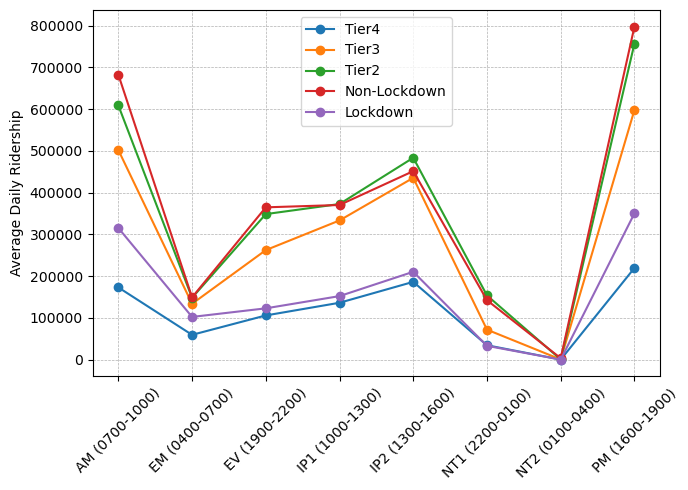

In [232]:
# Combining dataframes for easier plotting
combined_dataframes = {
    "Tier4": avg_weekdays_Tier4taps,
    "Tier3": avg_weekdays_Tier3taps,
    "Tier2": avg_weekdays_Tier2taps,
    "Non-Lockdown": avg_weekdays_nonlockdowntaps,
    "Lockdown": avg_weekdays_lockdowntaps
}

# Plotting the data
plt.figure(figsize=(7,5))
for lockdown_type, data in combined_dataframes.items():
    plt.plot(data["PERIOD"], data["AVERRAGE(N)"], label=lockdown_type, marker='o')

# plt.xlabel("PERIOD")
plt.ylabel("Average Daily Ridership")
#     plt.title("Average Daily Riding Patterns on the Tube During Weekdays Across Lockdown Phases in London")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.savefig('./Average Daily Riding Patterns on the Tube During Weekdays Across Lockdown Phases in London.png',  bbox_inches='tight',dpi=300)
plt.show()


In [163]:
data.DOW

AttributeError: 'DataFrame' object has no attribute 'DOW'

In [176]:
data['LOCKDOWN_REGIONAL'] = data['LOCKDOWN_REGIONAL'].astype(str)
# Filtering data for Weekdays (Monday to Friday)
df_weekENDS = data[data['DOW'].isin(['SAT','SUN'])]
# Group by 'CALENDARDATE' and 'STATIONTYPE' to get the sum of 'N' for each combination
aggregated_weekENDS = df_weekENDS.groupby(['CALENDARDATE','DOW', 'LOCKDOWN_REGIONAL','PERIOD'])['N'].sum().reset_index()

In [174]:
avg_weekENDS_lockdowntaps = aggregated_weekENDS[aggregated_weekENDS['LOCKDOWN_REGIONAL'] == '1']

In [175]:
data['LOCKDOWN_REGIONAL'] = data['LOCKDOWN_REGIONAL'].astype(str)

,CALENDARDATE,DOW,LOCKDOWN_REGIONAL,PERIOD,N


In [177]:
# Group by 'LOCKDOWN_NATIONAL' and 'STATIONTYPE' to compute the average taps during a lockdown for each station type
avg_weekENDS_lockdowntaps = aggregated_weekENDS[aggregated_weekENDS['LOCKDOWN_REGIONAL'] == '1'].groupby(['LOCKDOWN_REGIONAL','PERIOD'])['N'].mean().reset_index()

# Rename the 'N' column to 'Average_Taps'
avg_weekENDS_lockdowntaps.columns = ['LOCKDOWN_REGIONAL','PERIOD', 'AVERRAGE(N)']

avg_weekENDS_lockdowntaps

,LOCKDOWN_REGIONAL,PERIOD,AVERRAGE(N)
0,1,AM (0700-1000),91358.122449
1,1,EM (0400-0700),30071.081633
2,1,EV (1900-2200),84716.326531
3,1,IP1 (1000-1300),121755.795918
4,1,IP2 (1300-1600),176531.979592
5,1,NT1 (2200-0100),29828.836735
6,1,NT2 (0100-0400),185.775510
7,1,PM (1600-1900),156153.530612


In [178]:
# Group by 'LOCKDOWN_NATIONAL' and 'STATIONTYPE' to compute the average taps during a lockdown for each station type
avg_weekENDS_lockdowntaps = aggregated_weekENDS[aggregated_weekENDS['LOCKDOWN_REGIONAL'] == '1'].groupby(['LOCKDOWN_REGIONAL','PERIOD'])['N'].mean().reset_index()

# Rename the 'N' column to 'Average_Taps'
avg_weekENDS_lockdowntaps.columns = ['LOCKDOWN_REGIONAL','PERIOD', 'AVERRAGE(N)']

# Group by 'LOCKDOWN_NATIONAL' and 'STATIONTYPE' to compute the average taps during a lockdown for each station type
avg_weekENDS_NONlockdowntaps = aggregated_weekENDS[aggregated_weekENDS['LOCKDOWN_REGIONAL'] == '0'].groupby(['LOCKDOWN_REGIONAL','PERIOD'])['N'].mean().reset_index()

# Rename the 'N' column to 'Average_Taps'
avg_weekENDS_NONlockdowntaps.columns = ['LOCKDOWN_REGIONAL','PERIOD', 'AVERRAGE(N)']
# Group by 'LOCKDOWN_NATIONAL' and 'STATIONTYPE' to compute the average taps during a lockdown for each station type
avg_weekENDS_Tier2 = aggregated_weekENDS[aggregated_weekENDS['LOCKDOWN_REGIONAL'] == 'Tier2'].groupby(['LOCKDOWN_REGIONAL','PERIOD'])['N'].mean().reset_index()

# Rename the 'N' column to 'Average_Taps'
avg_weekENDS_Tier2.columns = ['LOCKDOWN_REGIONAL','PERIOD', 'AVERRAGE(N)']
# Group by 'LOCKDOWN_NATIONAL' and 'STATIONTYPE' to compute the average taps during a lockdown for each station type
avg_weekENDS_Tier3 = aggregated_weekENDS[aggregated_weekENDS['LOCKDOWN_REGIONAL'] == 'Tier3'].groupby(['LOCKDOWN_REGIONAL','PERIOD'])['N'].mean().reset_index()

# Rename the 'N' column to 'Average_Taps'
avg_weekENDS_Tier3.columns = ['LOCKDOWN_REGIONAL','PERIOD', 'AVERRAGE(N)']
# Group by 'LOCKDOWN_NATIONAL' and 'STATIONTYPE' to compute the average taps during a lockdown for each station type
avg_weekENDS_Tier4 = aggregated_weekENDS[aggregated_weekENDS['LOCKDOWN_REGIONAL'] == 'Tier4'].groupby(['LOCKDOWN_REGIONAL','PERIOD'])['N'].mean().reset_index()

# Rename the 'N' column to 'Average_Taps'
avg_weekENDS_Tier4.columns = ['LOCKDOWN_REGIONAL','PERIOD', 'AVERRAGE(N)']

In [183]:
avg_weekENDS_lockdowntaps

,LOCKDOWN_REGIONAL,PERIOD,AVERRAGE(N)
0,1,AM (0700-1000),91358.122449
1,1,EM (0400-0700),30071.081633
2,1,EV (1900-2200),84716.326531
3,1,IP1 (1000-1300),121755.795918
4,1,IP2 (1300-1600),176531.979592
5,1,NT1 (2200-0100),29828.836735
6,1,NT2 (0100-0400),185.775510
7,1,PM (1600-1900),156153.530612


In [184]:
avg_weekENDS_NONlockdowntaps

,LOCKDOWN_REGIONAL,PERIOD,AVERRAGE(N)
0,0,AM (0700-1000),189542.457143
1,0,EM (0400-0700),44313.214286
2,0,EV (1900-2200),267488.257143
3,0,IP1 (1000-1300),348183.814286
4,0,IP2 (1300-1600),439341.385714
5,0,NT1 (2200-0100),128754.842857
6,0,NT2 (0100-0400),9459.642857
7,0,PM (1600-1900),432880.457143


In [185]:
avg_weekENDS_Tier2

,LOCKDOWN_REGIONAL,PERIOD,AVERRAGE(N)
0,Tier2,AM (0700-1000),205771.25
1,Tier2,EM (0400-0700),44958.50
2,Tier2,EV (1900-2200),300373.00
3,Tier2,IP1 (1000-1300),407483.50
4,Tier2,IP2 (1300-1600),555792.00
5,Tier2,NT1 (2200-0100),150472.50
6,Tier2,NT2 (0100-0400),532.50
7,Tier2,PM (1600-1900),548195.50


In [186]:
avg_weekENDS_Tier3

,LOCKDOWN_REGIONAL,PERIOD,AVERRAGE(N)
0,Tier3,AM (0700-1000),205366.0
1,Tier3,EM (0400-0700),55273.0
2,Tier3,EV (1900-2200),234334.0
3,Tier3,IP1 (1000-1300),311879.0
4,Tier3,IP2 (1300-1600),439566.0
5,Tier3,NT1 (2200-0100),77849.0
6,Tier3,NT2 (0100-0400),602.0
7,Tier3,PM (1600-1900),414502.0


In [187]:
avg_weekENDS_Tier4

,LOCKDOWN_REGIONAL,PERIOD,AVERRAGE(N)
0,Tier4,AM (0700-1000),69813.6
1,Tier4,EM (0400-0700),16406.2
2,Tier4,EV (1900-2200),79392.8
3,Tier4,IP1 (1000-1300),105742.6
4,Tier4,IP2 (1300-1600),160834.8
5,Tier4,NT1 (2200-0100),28419.4
6,Tier4,NT2 (0100-0400),158.6
7,Tier4,PM (1600-1900),145060.4


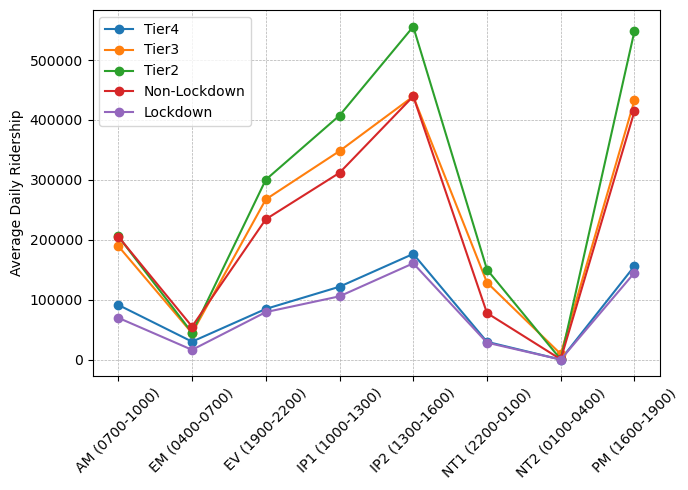

In [233]:
# Combining dataframes for easier plotting
combined_dataframes = {
    "Tier4": avg_weekENDS_lockdowntaps,
    "Tier3": avg_weekENDS_NONlockdowntaps,
    "Tier2": avg_weekENDS_Tier2,
    "Non-Lockdown": avg_weekENDS_Tier3,
    "Lockdown": avg_weekENDS_Tier4
}

# Plotting the data
plt.figure(figsize=(7,5))
for lockdown_type, data in combined_dataframes.items():
    plt.plot(data["PERIOD"], data["AVERRAGE(N)"], label=lockdown_type, marker='o')

# plt.xlabel("PERIOD")
plt.ylabel("Average Daily Ridership")
#     plt.title("Average Daily Riding Patterns on the Tube During Weekdays Across Lockdown Phases in London")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.savefig('./Average Daily Riding Patterns on the Tube During WeekENDs Across Lockdown Phases in London.png',  bbox_inches='tight',dpi=300)
plt.show()


# Lockdown Regional

In [82]:
# Group by 'CALENDARDATE' and 'STATIONTYPE' to get the sum of 'N' for each combination
aggregated_df = data.groupby(['CALENDARDATE', 'LOCKDOWN_REGIONAL','STATIONTYPE'])['N'].sum().reset_index()

# Rename columns for clarity
aggregated_df.columns = ['CALENDARDATE','LOCKDOWN_REGIONAL', 'STATIONTYPE', 'N']

aggregated_df.head()

,CALENDARDATE,LOCKDOWN_REGIONAL,STATIONTYPE,N
0,2020-02-02,0,Airport,27
1,2020-02-02,0,City,238185
2,2020-02-02,0,Inner Suburb,1035229
3,2020-02-02,0,Outer Suburb,825567
4,2020-02-02,0,Shopping,470260


In [83]:
data['LOCKDOWN_REGIONAL'].value_counts()

0        9542853
1        6401580
Tier2     576817
Tier4     567849
Tier3     165559
Name: LOCKDOWN_REGIONAL, dtype: int64

In [89]:
# Group by 'LOCKDOWN_NATIONAL' and 'STATIONTYPE' to compute the average taps during a lockdown for each station type
daily_taps_lockdown = aggregated_df[aggregated_df['LOCKDOWN_REGIONAL'] == '1'].groupby(['LOCKDOWN_REGIONAL', 'STATIONTYPE'])['N'].sum().reset_index()

# Rename the 'N' column to 'Average_Taps'
daily_taps_lockdown.columns = ['LOCKDOWN_REGIONAL', 'STATIONTYPE', 'N']
total_N = daily_taps_lockdown['N'].sum()
# Calculate relative percentage change
daily_taps_lockdown['percentage_contribution']= (daily_taps_lockdown['N'] / total_N * 100).round(2)
daily_taps_lockdown

,LOCKDOWN_REGIONAL,STATIONTYPE,N,percentage_contribution
0,1,Airport,669779,0.35
1,1,City,11947258,6.18
2,1,Inner Suburb,58202352,30.08
3,1,Outer Suburb,66620743,34.44
4,1,Shopping,17719665,9.16
5,1,Terminus,24937838,12.89
6,1,Tourist,13366526,6.91


In [91]:
# Group by 'LOCKDOWN_NATIONAL' and 'STATIONTYPE' to compute the average taps during a lockdown for each station type
daily_taps_notlockdown = aggregated_df[aggregated_df['LOCKDOWN_REGIONAL'] == '0'].groupby(['LOCKDOWN_REGIONAL', 'STATIONTYPE'])['N'].sum().reset_index()

# Rename the 'N' column to 'Average_Taps'
daily_taps_notlockdown.columns = ['LOCKDOWN_REGIONAL', 'STATIONTYPE', 'N']
total_N = daily_taps_notlockdown['N'].sum()
# Calculate relative percentage change
daily_taps_notlockdown['percentage_contribution']= (daily_taps_notlockdown['N'] / total_N * 100).round(2)
daily_taps_notlockdown

,LOCKDOWN_REGIONAL,STATIONTYPE,N,percentage_contribution
0,0,Airport,2669639,0.41
1,0,City,54261699,8.33
2,0,Inner Suburb,176284908,27.06
3,0,Outer Suburb,179551530,27.56
4,0,Shopping,77511221,11.90
5,0,Terminus,101868884,15.64
6,0,Tourist,59251865,9.10


In [95]:
# Group by 'LOCKDOWN_NATIONAL' and 'STATIONTYPE' to compute the average taps during a lockdown for each station type
daily_taps_Tier2 = aggregated_df[aggregated_df['LOCKDOWN_REGIONAL'] == 'Tier2'].groupby(['LOCKDOWN_REGIONAL', 'STATIONTYPE'])['N'].sum().reset_index()

# Rename the 'N' column to 'Average_Taps'
daily_taps_Tier2.columns = ['LOCKDOWN_REGIONAL', 'STATIONTYPE', 'N']
total_N = daily_taps_Tier2['N'].sum()
# Calculate relative percentage change
daily_taps_Tier2['percentage_contribution']= (daily_taps_Tier2['N'] / total_N * 100).round(2)
daily_taps_Tier2

,LOCKDOWN_REGIONAL,STATIONTYPE,N,percentage_contribution
0,Tier2,Airport,111169,0.30
1,Tier2,City,2410098,6.41
2,Tier2,Inner Suburb,10670239,28.39
3,Tier2,Outer Suburb,10855681,28.89
4,Tier2,Shopping,5139847,13.68
5,Tier2,Terminus,5057740,13.46
6,Tier2,Tourist,3337469,8.88


In [96]:
# Group by 'LOCKDOWN_NATIONAL' and 'STATIONTYPE' to compute the average taps during a lockdown for each station type
daily_taps_Tier3 = aggregated_df[aggregated_df['LOCKDOWN_REGIONAL'] == 'Tier3'].groupby(['LOCKDOWN_REGIONAL', 'STATIONTYPE'])['N'].sum().reset_index()

# Rename the 'N' column to 'Average_Taps'
daily_taps_Tier3.columns = ['LOCKDOWN_REGIONAL', 'STATIONTYPE', 'N']
total_N = daily_taps_Tier3['N'].sum()
# Calculate relative percentage change
daily_taps_Tier3['percentage_contribution']= (daily_taps_Tier3['N'] / total_N * 100).round(2)
daily_taps_Tier3

,LOCKDOWN_REGIONAL,STATIONTYPE,N,percentage_contribution
0,Tier3,Airport,43616,0.50
1,Tier3,City,527696,6.03
2,Tier3,Inner Suburb,2493912,28.50
3,Tier3,Outer Suburb,2694965,30.80
4,Tier3,Shopping,1198167,13.69
5,Tier3,Terminus,1136922,12.99
6,Tier3,Tourist,655712,7.49


In [97]:
# Group by 'LOCKDOWN_NATIONAL' and 'STATIONTYPE' to compute the average taps during a lockdown for each station type
daily_taps_Tier4 = aggregated_df[aggregated_df['LOCKDOWN_REGIONAL'] == 'Tier4'].groupby(['LOCKDOWN_REGIONAL', 'STATIONTYPE'])['N'].sum().reset_index()

# Rename the 'N' column to 'Average_Taps'
daily_taps_Tier4.columns = ['LOCKDOWN_REGIONAL', 'STATIONTYPE', 'N']
total_N = daily_taps_Tier4['N'].sum()
# Calculate relative percentage change
daily_taps_Tier4['percentage_contribution']= (daily_taps_Tier4['N'] / total_N * 100).round(2)
daily_taps_Tier4

,LOCKDOWN_REGIONAL,STATIONTYPE,N,percentage_contribution
0,Tier4,Airport,71359,0.55
1,Tier4,City,749227,5.81
2,Tier4,Inner Suburb,3925420,30.43
3,Tier4,Outer Suburb,4355428,33.76
4,Tier4,Shopping,1256526,9.74
5,Tier4,Terminus,1656767,12.84
6,Tier4,Tourist,886597,6.87


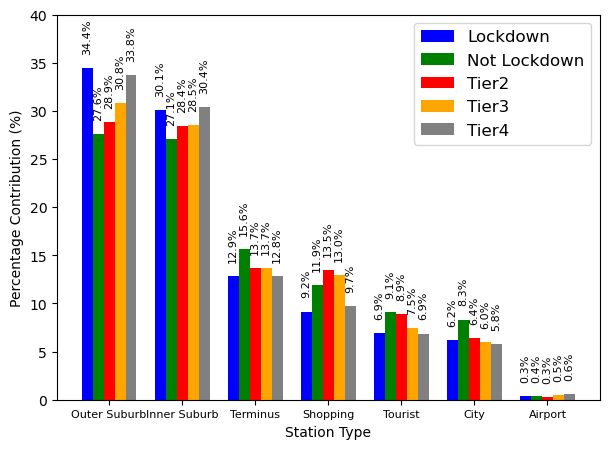

In [239]:
import matplotlib.pyplot as plt

# Define necessary variables for plotting
bar_width = 0.15
index = np.arange(len(daily_taps_lockdown['STATIONTYPE']))
positions = [index + i*bar_width for i in range(5)]

# Sorting the dataframes based on 'percentage_contribution' in descending order for better visualization
daily_taps_lockdown = daily_taps_lockdown.sort_values(by='percentage_contribution', ascending=False).reset_index(drop=True)
daily_taps_notlockdown = daily_taps_notlockdown.sort_values(by='percentage_contribution', ascending=False).reset_index(drop=True)
daily_taps_Tier2 = daily_taps_Tier2.sort_values(by='percentage_contribution', ascending=False).reset_index(drop=True)
daily_taps_Tier3 = daily_taps_Tier3.sort_values(by='percentage_contribution', ascending=False).reset_index(drop=True)
daily_taps_Tier4 = daily_taps_Tier4.sort_values(by='percentage_contribution', ascending=False).reset_index(drop=True)
def annotate_bars(bars, ax, spacing=10):
    for bar in bars:
        y_value = bar.get_height()
        x_value = bar.get_x() + bar.get_width() / 2
        va = 'bottom'
        ax.annotate(
             f"{y_value:.1f}%",
            (x_value, y_value),
            xytext=(0, spacing),
            textcoords="offset points",
            ha='center',
            va=va,
            fontsize=8,
            rotation=90
        )
# Plotting
plt.figure(figsize=(7, 5))
ax = plt.gca()

# Define variables for plotting
bar_width = 0.15
index = np.arange(len(daily_taps_lockdown['STATIONTYPE']))
positions = [index + i*bar_width for i in range(5)]

# Plotting bars for all dataframes
bars_lockdown = plt.bar(positions[0], daily_taps_lockdown['percentage_contribution'], bar_width, label='Lockdown', color='blue')
bars_notlockdown = plt.bar(positions[1], daily_taps_notlockdown['percentage_contribution'], bar_width, label='Not Lockdown', color='green')
bars_Tier2 = plt.bar(positions[2], daily_taps_Tier2['percentage_contribution'], bar_width, label='Tier2', color='red')
bars_Tier3 = plt.bar(positions[3], daily_taps_Tier3['percentage_contribution'], bar_width, label='Tier3', color='orange')
bars_Tier4 = plt.bar(positions[4], daily_taps_Tier4['percentage_contribution'], bar_width, label='Tier4', color='grey')

# Annotate the bars
annotate_bars(bars_lockdown, ax)
annotate_bars(bars_notlockdown, ax)
annotate_bars(bars_Tier2, ax)
annotate_bars(bars_Tier3, ax)
annotate_bars(bars_Tier4, ax)

plt.xlabel('Station Type')
plt.ylabel('Percentage Contribution (%)')
plt.xticks(index + 2*bar_width, daily_taps_lockdown['STATIONTYPE'],fontsize=8)  
plt.legend(fontsize=12)
plt.ylim(0,40)
#Uncomment the next line if you wish to save the figure
plt.savefig('./Percentage_Contribution_by_Station_type_during_Lockdown.png',  bbox_inches='tight',dpi=300)

plt.show()

# Lockdown National

In [64]:
# Group by 'CALENDARDATE' and 'STATIONTYPE' to get the sum of 'N' for each combination
aggregated_df = data.groupby(['CALENDARDATE', 'LOCKDOWN_NATIONAL','STATIONTYPE'])['N'].sum().reset_index()

# Rename columns for clarity
aggregated_df.columns = ['CALENDARDATE','LOCKDOWN_NATIONAL', 'STATIONTYPE', 'N']

aggregated_df.head()

,CALENDARDATE,LOCKDOWN_NATIONAL,STATIONTYPE,N
0,2020-02-02,0,Airport,27
1,2020-02-02,0,City,238185
2,2020-02-02,0,Inner Suburb,1035229
3,2020-02-02,0,Outer Suburb,825567
4,2020-02-02,0,Shopping,470260


In [72]:
# Group by 'LOCKDOWN_NATIONAL' and 'STATIONTYPE' to compute the average taps during a lockdown for each station type
daily_taps_lockdown = aggregated_df[aggregated_df['LOCKDOWN_NATIONAL'] == 1].groupby(['LOCKDOWN_NATIONAL', 'STATIONTYPE'])['N'].sum().reset_index()

# Rename the 'N' column to 'Average_Taps'
daily_taps_lockdown.columns = ['LOCKDOWN_NATIONAL', 'STATIONTYPE', 'N']
total_N = daily_taps_lockdown['N'].sum()
# Calculate relative percentage change
daily_taps_lockdown['percentage_contribution']= (daily_taps_lockdown['N'] / total_N * 100).round(2)
daily_taps_lockdown

,LOCKDOWN_NATIONAL,STATIONTYPE,N,percentage_contribution
0,1,Airport,669779,0.35
1,1,City,11947258,6.18
2,1,Inner Suburb,58202352,30.08
3,1,Outer Suburb,66620743,34.44
4,1,Shopping,17719665,9.16
5,1,Terminus,24937838,12.89
6,1,Tourist,13366526,6.91


In [69]:
daily_taps_lockdown.Percentage

0     0.35
1     6.18
2    30.08
3    34.44
4     9.16
5    12.89
6     6.91
Name: Percentage, dtype: float64

In [73]:
# Group by 'LOCKDOWN_NATIONAL' and 'STATIONTYPE' to compute the average taps during a lockdown for each station type
daily_taps_notlockdown = aggregated_df[aggregated_df['LOCKDOWN_NATIONAL'] == 0].groupby(['LOCKDOWN_NATIONAL', 'STATIONTYPE'])['N'].sum().reset_index()

# Rename the 'N' column to 'Average_Taps'
daily_taps_notlockdown.columns = ['LOCKDOWN_NATIONAL', 'STATIONTYPE', 'N']
total_N = daily_taps_notlockdown['N'].sum()
# Calculate relative percentage change
daily_taps_notlockdown['percentage_contribution']= (daily_taps_notlockdown['N'] / total_N * 100).round(2)
daily_taps_notlockdown

,LOCKDOWN_NATIONAL,STATIONTYPE,N,percentage_contribution
0,0,Airport,2895783,0.41
1,0,City,57948720,8.15
2,0,Inner Suburb,193374479,27.21
3,0,Outer Suburb,197457604,27.79
4,0,Shopping,85105761,11.98
5,0,Terminus,109720313,15.44
6,0,Tourist,64131643,9.02


In [71]:
daily_taps_notlockdown.Percentage

0     0.41
1     8.15
2    27.21
3    27.79
4    11.98
5    15.44
6     9.02
Name: Percentage, dtype: float64

In [40]:
daily_taps_lockdown

,LOCKDOWN_NATIONAL,STATIONTYPE,N,percentage_contribution
0,1,Airport,669779,0.346203
1,1,City,11947258,6.175437
2,1,Inner Suburb,58202352,30.084307
3,1,Outer Suburb,66620743,34.435703
4,1,Shopping,17719665,9.159146
5,1,Terminus,24937838,12.890159
6,1,Tourist,13366526,6.909045


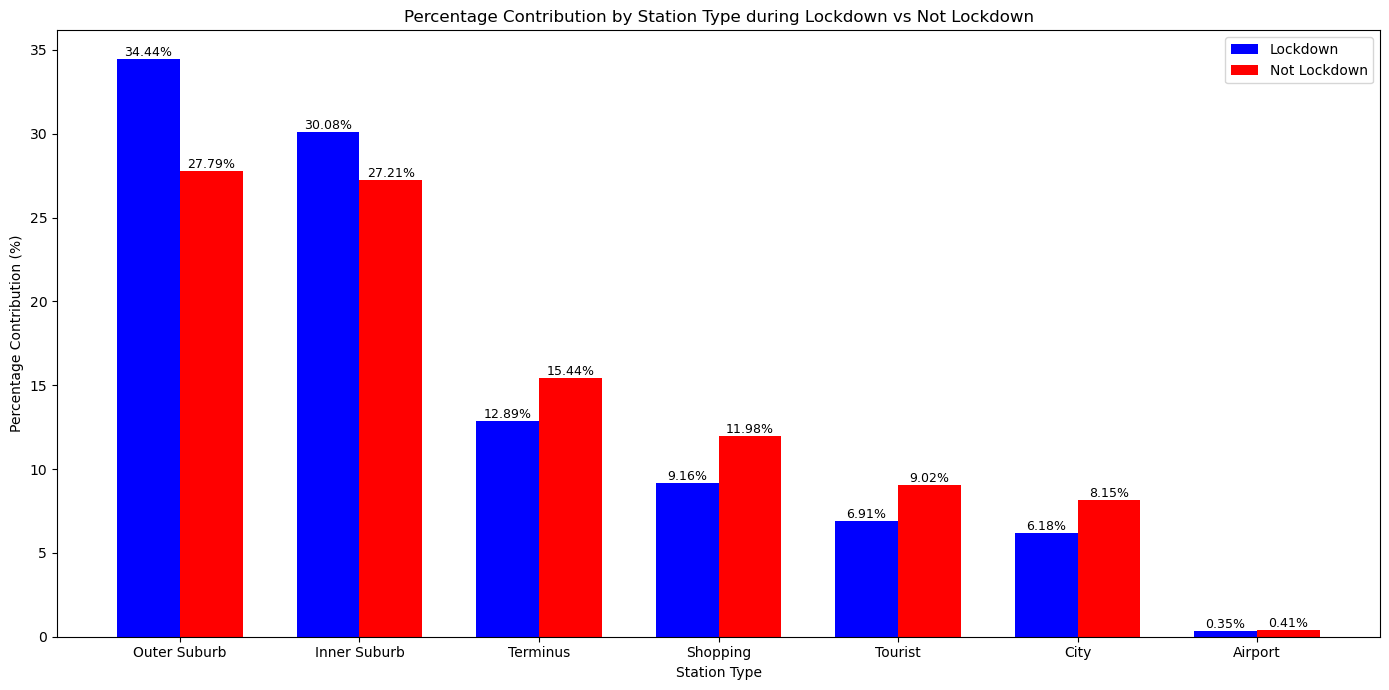

In [80]:
# Sorting the dataframes based on 'percentage_contribution' in descending order for better visualization
daily_taps_lockdown = daily_taps_lockdown.sort_values(by='percentage_contribution', ascending=False).reset_index(drop=True)
daily_taps_notlockdown = daily_taps_notlockdown.sort_values(by='percentage_contribution', ascending=False).reset_index(drop=True)


# Define necessary variables for plotting
bar_width = 0.35
index = np.arange(len(daily_taps_lockdown['STATIONTYPE']))

# Produce the combined bar plot
plt.figure(figsize=(14, 7))
# Plotting bars for lockdown and notlockdown data
bars_lockdown = plt.bar(index, daily_taps_lockdown['percentage_contribution'], bar_width, label='Lockdown', color='blue')
bars_notlockdown = plt.bar(index + bar_width, daily_taps_notlockdown['percentage_contribution'], bar_width, label='Not Lockdown', color='red')

# Function to annotate bars with their percentages
def annotate_bars(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height, '%.2f%%' % height, ha='center', va='bottom', fontsize=9)

# Annotating the bars with their percentages
annotate_bars(bars_lockdown)
annotate_bars(bars_notlockdown)
plt.xlabel('Station Type')
plt.ylabel('Percentage Contribution (%)')
plt.title('Percentage Contribution by Station Type during Lockdown vs Not Lockdown')
plt.xticks(index + bar_width / 2, daily_taps_lockdown['STATIONTYPE'])
plt.legend()
plt.tight_layout()
plt.savefig('./Percentage Contribution by Station type during Lockdown vs Not Lockdown.png',  bbox_inches='tight')
plt.show();

In [18]:
daily_taps_notlockdown=aggregated_df[aggregated_df['LOCKDOWN_NATIONAL']==0]
total_N = daily_taps_notlockdown['N'].sum()
# Calculate relative percentage change
daily_taps_notlockdown['percentage_contribution ']= (daily_taps_notlockdown['N']) / total_N * 100
daily_taps_notlockdown

,CALENDARDATE,LOCKDOWN_NATIONAL,STATIONTYPE,N,percentage_contribution
0,2020-02-02,0,Airport,27,0.000004
1,2020-02-02,0,City,238185,0.033517
2,2020-02-02,0,Inner Suburb,1035229,0.145677
3,2020-02-02,0,Outer Suburb,825567,0.116173
4,2020-02-02,0,Shopping,470260,0.066175
...,...,...,...,...,...
3160,2021-04-29,0,Inner Suburb,836368,0.117693
3161,2021-04-29,0,Outer Suburb,877436,0.123472
3162,2021-04-29,0,Shopping,322793,0.045423
3163,2021-04-29,0,Terminus,408617,0.057500


In [ ]:
daily_taps_notlockdown=average_taps[average_taps['LOCKDOWN_NATIONAL']==0]
total_N = daily_taps_notlockdown['N'].sum()
# Calculate relative percentage change
daily_taps_notlockdown['percentage_contribution ']= (daily_taps_notlockdown['N']) / total_N * 100

daily_taps_lockdown=average_taps[average_taps['LOCKDOWN_NATIONAL']==1]
total_N = daily_taps_lockdown['N'].sum()
# Calculate relative percentage change
daily_taps_lockdown['percentage_contribution ']= (daily_taps_lockdown['N']) / total_N * 100

### **Data Preprocessing**

1.  **Handling Missing Values**:All the NaN values extracted after adding lag features dataset are replaced with zeros.
2.   **Mapping Categorical to Numerical:**Days of the week ('DOW') and entry/exit status ('ENTRYEXIT') are mapped to numerical values using label encoding for easier processing by machine learning algorithms.

1. **Date Transformation:** The 'CALENDARDATE' is converted to a datetime format.

In [73]:
def perform_categorical_mapping(data, column_name, mapping_dict):
    data[column_name] = data[column_name].replace(mapping_dict)
    return data

# Mapping for day of week (DOW) feature
dow_mapping = {'MON': 1, 'TUE': 2, 'WED': 3, 'THU': 4, 'FRI': 5, 'SAT': 6, 'SUN': 7}
data = perform_categorical_mapping(data, 'DOW', dow_mapping)

# Mapping for ENTRYEXIT feature
entry_exit_mapping = {'Entry': 0, 'Exit': 1}
data = perform_categorical_mapping(data, 'ENTRYEXIT', entry_exit_mapping)

In [74]:
def extract_date_features(data, date_column_name):
    data[date_column_name] = pd.to_datetime(data[date_column_name])
    data['Year'] = data[date_column_name].dt.year.replace({2020: 0, 2021: 1}).astype('int8')
    data['Month'] = data[date_column_name].dt.month.astype('int8')
    data['Day'] = data[date_column_name].dt.day.astype('int8')
    data['Quarter'] = data[date_column_name].dt.quarter.astype('int8')
    data['Is_Weekend'] = data['DOW'].apply(lambda x: 1 if x in [6, 7] else 0).astype('int8')
    data['week_of_month'] = (data[date_column_name].dt.day + data[date_column_name].dt.dayofweek) // 7 + 1
    
    categorical_columns = ['Month', 'Day', 'Quarter', 'Is_Weekend', 'Year', 'ENTRYEXIT', 'week_of_month', 'SHOPS_CLOSED', 'PUBS_CLOSED', 'SCHOOLS_CLOSED', 'DOW']
    data[categorical_columns] = data[categorical_columns].astype('int8')
    
    return data

data = extract_date_features(data, 'CALENDARDATE')

### **Feature Engineering:**
The code is designed to enhance a time-series dataset about the London Underground by adding "lagged" features. These features capture historical data points to help make better future predictions. Here's the breakdown:

**Sorting:** The data is sorted by date, station name, National Location Code (NLC), hour, and entry/exit status. This ensures that the data is in the right order for creating lagged features.

**Lagged Features:** A new column is added for each of three specified time lags—7, 14, and 21 time units ago. These lagged features represent the number of taps (N) at the station at those previous times.

**Grouping**: The lagged features are created within groups that share the same station name, NLC, hour, and entry/exit status. This means the lagged data is specific to each unique combination of these variables.

**Time Units:** The lags of 7, 14, and 21 could represent days, hours, or any other time unit, depending on the context. They are chosen to capture weekly patterns in the data.

By adding these lagged features, the dataset gains historical context, which can improve the performance of time-series forecasting models like XGBoost Regressor.

**Date Features**: New features like 'Year', 'Month', 'Day', and 'Quarter' are created based on the 'CALENDARDATE' to capture any seasonal or time-based patterns.A binary feature 'Is_Weekend' is created to indicate whether a day is a weekend.

**One-Hot Encoding:** Categorical variables like 'STATIONTYPE', and 'LOCKDOWN_REGIONAL' are one-hot encoded.

**Mean encoding:** Station name feature is mean encoded. In mean encoding, each unique value of the categorical variable ("stationname" in this case) is replaced with the mean of the target variable ("N") corresponding to that category.

In [75]:
data.head(2)

,CALENDARDATE,DOW,NLC,HOUR,ENTRYEXIT,N,ZONE,LOCKDOWN_REGIONAL,SHOPS_CLOSED,PUBS_CLOSED,SCHOOLS_CLOSED,STATIONNAME,STATIONTYPE,Year,Month,Day,Quarter,Is_Weekend,week_of_month
0,2020-02-02,7,501,6.75,0,10,1.0,0,0,0,0,Barbican,City,0,2,2,1,1,2
1,2020-02-02,7,501,6.75,1,17,1.0,0,0,0,0,Barbican,City,0,2,2,1,1,2


In [76]:
def one_hot_encode_and_convert_to_int8(data, categorical_columns):
     
    # Convert LOCKDOWN_REGIONAL to string before one-hot encoding
    data['LOCKDOWN_REGIONAL'] = data['LOCKDOWN_REGIONAL'].astype(str)
    
    data = pd.get_dummies(data, columns=categorical_columns, dtype='int8')
    return data

# Assuming 'data' is your DataFrame
categorical_columns = ['STATIONTYPE', 'LOCKDOWN_REGIONAL']
data = one_hot_encode_and_convert_to_int8(data, categorical_columns)

In [37]:
# data = pd.get_dummies(data, columns=['STATIONTYPE','LOCKDOWN_REGIONAL'])
# # List of columns to convert to int8
# dummy_columns = [col for col in data.columns if 'STATIONTYPE_' in col or 'LOCKDOWN_REGIONAL_' in col]

# # Convert the dummy columns to int8 data type
# for col in dummy_columns:
#     data[col] = data[col].astype('int8')

In [53]:
data.head(2)

,CALENDARDATE,DOW,NLC,HOUR,ENTRYEXIT,N,ZONE,SHOPS_CLOSED,PUBS_CLOSED,SCHOOLS_CLOSED,...,STATIONTYPE_Inner Suburb,STATIONTYPE_Outer Suburb,STATIONTYPE_Shopping,STATIONTYPE_Terminus,STATIONTYPE_Tourist,LOCKDOWN_REGIONAL_0,LOCKDOWN_REGIONAL_1,LOCKDOWN_REGIONAL_Tier2,LOCKDOWN_REGIONAL_Tier3,LOCKDOWN_REGIONAL_Tier4
0,2020-02-02,7,501,6.75,0,10,1.0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,2020-02-02,7,501,6.75,1,17,1.0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [77]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17254658 entries, 0 to 17254657
Data columns (total 29 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   CALENDARDATE              datetime64[ns]
 1   DOW                       int8          
 2   NLC                       int64         
 3   HOUR                      float64       
 4   ENTRYEXIT                 int8          
 5   N                         int64         
 6   ZONE                      float64       
 7   SHOPS_CLOSED              int8          
 8   PUBS_CLOSED               int8          
 9   SCHOOLS_CLOSED            int8          
 10  STATIONNAME               object        
 11  Year                      int8          
 12  Month                     int8          
 13  Day                       int8          
 14  Quarter                   int8          
 15  Is_Weekend                int8          
 16  week_of_month             int8          
 17  STATIO

In [78]:
def create_lag_features(data, lag_features, lags):
    for feature in lag_features:
        for lag in lags:
            lag_col_name = f"{feature}_lag{lag}"
            data[lag_col_name] = data.groupby(['STATIONNAME', 'NLC', 'HOUR', 'ENTRYEXIT'])[feature].shift(lag)
    return data

# Assuming 'data' is your DataFrame
lag_features = ['N']
lags = [7, 14, 21]

data = data.sort_values(['CALENDARDATE', 'STATIONNAME', 'NLC', 'HOUR', 'ENTRYEXIT'])
data = create_lag_features(data, lag_features, lags)

In [56]:
data.head(2)

,CALENDARDATE,DOW,NLC,HOUR,ENTRYEXIT,N,ZONE,SHOPS_CLOSED,PUBS_CLOSED,SCHOOLS_CLOSED,...,STATIONTYPE_Terminus,STATIONTYPE_Tourist,LOCKDOWN_REGIONAL_0,LOCKDOWN_REGIONAL_1,LOCKDOWN_REGIONAL_Tier2,LOCKDOWN_REGIONAL_Tier3,LOCKDOWN_REGIONAL_Tier4,N_lag7,N_lag14,N_lag21
142,2020-02-02,7,502,6.25,0,1,1.0,0,0,0,...,0,0,1,0,0,0,0,NaN,NaN,NaN
143,2020-02-02,7,502,6.75,0,15,1.0,0,0,0,...,0,0,1,0,0,0,0,NaN,NaN,NaN


In [79]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17254658 entries, 142 to 17251829
Data columns (total 32 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   CALENDARDATE              datetime64[ns]
 1   DOW                       int8          
 2   NLC                       int64         
 3   HOUR                      float64       
 4   ENTRYEXIT                 int8          
 5   N                         int64         
 6   ZONE                      float64       
 7   SHOPS_CLOSED              int8          
 8   PUBS_CLOSED               int8          
 9   SCHOOLS_CLOSED            int8          
 10  STATIONNAME               object        
 11  Year                      int8          
 12  Month                     int8          
 13  Day                       int8          
 14  Quarter                   int8          
 15  Is_Weekend                int8          
 16  week_of_month             int8          
 17  STAT

In [29]:
data[(data["CALENDARDATE"] == "2020-02-3") & (data["STATIONNAME"] == "Stratford")  & (data["NLC"] == 719) & (data["HOUR"] == 9.00) &(data["ENTRYEXIT"] == 0)]

,CALENDARDATE,DOW,NLC,HOUR,ENTRYEXIT,N,ZONE,SHOPS_CLOSED,PUBS_CLOSED,SCHOOLS_CLOSED,...,STATIONTYPE__Tourist,STATIONTYPE__0,STATIONTYPE__1,STATIONTYPE__1,STATIONTYPE__Tier2,STATIONTYPE__Tier3,STATIONTYPE__Tier4,N_lag7,N_lag14,N_lag21
69151,2020-02-03,1,719,9.0,0,1481,3.0,0,0,0,...,0,1,0,0,0,0,0,NaN,NaN,NaN


In [30]:
data[(data["CALENDARDATE"] == "2020-02-10") & (data["STATIONNAME"] == "Stratford")  & (data["NLC"] == 719) & (data["HOUR"] == 9.00) &(data["ENTRYEXIT"] == 0)]

,CALENDARDATE,DOW,NLC,HOUR,ENTRYEXIT,N,ZONE,SHOPS_CLOSED,PUBS_CLOSED,SCHOOLS_CLOSED,...,STATIONTYPE__Tourist,STATIONTYPE__0,STATIONTYPE__1,STATIONTYPE__1,STATIONTYPE__Tier2,STATIONTYPE__Tier3,STATIONTYPE__Tier4,N_lag7,N_lag14,N_lag21
364648,2020-02-10,1,719,9.0,0,1519,3.0,0,0,0,...,0,1,0,0,0,0,0,1481.0,NaN,NaN


In [80]:
def perform_mean_encoding_and_save(data, target_col, value_col, json_filename):
    mean_encoding_map = data.groupby(target_col)[value_col].transform('mean').astype(int)
    data[target_col + '_mean_encoded'] = mean_encoding_map
    station_mean_encoded_dict = dict(zip(data[target_col], mean_encoding_map))
    
    with open(json_filename, 'w') as json_file:
        json.dump(station_mean_encoded_dict, json_file)
    
    data.drop(columns=[target_col], inplace=True)
    return data

data = perform_mean_encoding_and_save(data, 'STATIONNAME', 'N', 'station_mean_encoded.json')

In [82]:
sample=merge_data[(merge_data["CALENDARDATE"] >= "2021-02-07") & (merge_data["CALENDARDATE"] >= "2021-02-28")]
sample.to_csv('sample_for_deployment.csv')

In [ ]:
merge_data.STATIONNAME.

In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17254658 entries, 142 to 17251829
Data columns (total 32 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   CALENDARDATE              datetime64[ns]
 1   DOW                       int8          
 2   NLC                       int64         
 3   HOUR                      float64       
 4   ENTRYEXIT                 int8          
 5   N                         int64         
 6   ZONE                      float64       
 7   SHOPS_CLOSED              int8          
 8   PUBS_CLOSED               int8          
 9   SCHOOLS_CLOSED            int8          
 10  Year                      int8          
 11  Month                     int8          
 12  Day                       int8          
 13  Quarter                   int8          
 14  Is_Weekend                int8          
 15  week_of_month             int8          
 16  STATIONTYPE_Airport       int8          
 17  STAT

In [60]:
data.isnull().any()

CALENDARDATE                False
DOW                         False
NLC                         False
HOUR                        False
ENTRYEXIT                   False
N                           False
ZONE                        False
SHOPS_CLOSED                False
PUBS_CLOSED                 False
SCHOOLS_CLOSED              False
Year                        False
Month                       False
Day                         False
Quarter                     False
Is_Weekend                  False
week_of_month               False
STATIONTYPE_Airport         False
STATIONTYPE_City            False
STATIONTYPE_Inner Suburb    False
STATIONTYPE_Outer Suburb    False
STATIONTYPE_Shopping        False
STATIONTYPE_Terminus        False
STATIONTYPE_Tourist         False
LOCKDOWN_REGIONAL_0         False
LOCKDOWN_REGIONAL_1         False
LOCKDOWN_REGIONAL_Tier2     False
LOCKDOWN_REGIONAL_Tier3     False
LOCKDOWN_REGIONAL_Tier4     False
N_lag7                       True
N_lag14       

# Rough work


In [87]:
def week_of_month(dt):
    """ Returns the week of the month for the specified date.
    """
    first_day = dt.replace(day=1)
    dom = dt.day
    adjusted_dom = dom + first_day.weekday()
    return int(ceil(adjusted_dom/7.0))

def extract_date(string_1):

    string_1 = pd.to_datetime(
    string_1.replace('/','-'),
    format='%d-%m-%Y'
    )
    year = string_1.year.replace({2020: 0, 2021: 1}).astype('int8')
    month = string_1.month
    day_of_week = string_1.dayofweek
    is_weekend = 1 if (day_of_week ==5) or (day_of_week==6)  else 0
    week = string_1.week
    week_month = week_of_month(string_1)
    return year,month,day_of_week,is_weekend,week,week_month
extract_date("20/08/2021")


def extract_date_features(data, date_column_name):
    data[date_column_name] = pd.to_datetime(data[date_column_name])
    data['Year'] = data[date_column_name].dt.year.replace({2020: 0, 2021: 1}).astype('int8')
    data['Month'] = data[date_column_name].dt.month.astype('int8')
    data['Day'] = data[date_column_name].dt.day.astype('int8')
    data['Quarter'] = data[date_column_name].dt.quarter.astype('int8')
    data['Is_Weekend'] = data['DOW'].apply(lambda x: 1 if x in [6, 7] else 0).astype('int8')
    data['week_of_month'] = (data[date_column_name].dt.day + data[date_column_name].dt.dayofweek) // 7 + 1
    
    categorical_columns = ['Month', 'Day', 'Quarter', 'Is_Weekend', 'Year', 'ENTRYEXIT', 'week_of_month', 'SHOPS_CLOSED', 'PUBS_CLOSED', 'SCHOOLS_CLOSED', 'DOW']
    data[categorical_columns] = data[categorical_columns].astype('int8')
    
    return data

data = extract_date_features(data, 'CALENDARDATE')

(2021, 8, 4, 0, 33, 4)

In [89]:
with open("station_mean_encoded.json","r") as f:
    df_station_mean = json.load(f)

In [99]:
station_name = "Stratford"
if station_name in df_station_mean:
    station_mean_encode = df_station_mean[station_name]
station_mean_encode

187

In [94]:
string_1.year.replace({2020: 0, 2021: 1}).astype('int8')

NameError: name 'string_1' is not defined

In [88]:
# Replace NaN values generated by lags with 0
data.fillna(0, inplace=True)

KeyboardInterrupt: 

In [69]:
data.head(2)

,CALENDARDATE,DOW,NLC,HOUR,ENTRYEXIT,N,ZONE,SHOPS_CLOSED,PUBS_CLOSED,SCHOOLS_CLOSED,...,LOCKDOWN_REGIONAL_0,LOCKDOWN_REGIONAL_1,LOCKDOWN_REGIONAL_1,LOCKDOWN_REGIONAL_Tier2,LOCKDOWN_REGIONAL_Tier3,LOCKDOWN_REGIONAL_Tier4,N_lag7,N_lag14,N_lag21,STATIONNAME_mean_encoded
142,2020-02-02,7,502,6.25,0,1,1.0,0,0,0,...,1,0,0,0,0,0,0.0,0.0,0.0,38
143,2020-02-02,7,502,6.75,0,15,1.0,0,0,0,...,1,0,0,0,0,0,0.0,0.0,0.0,38


In [30]:
# Convert the DataFrame to a NumPy array
numpy_array = data.values

# Save the NumPy array to a file
file_path = "data.npy"
np.save(file_path, numpy_array)

In [3]:
# Specify the path to your .npy file
file_path = "./data.npy"

# Load the NumPy array from the file
loaded_data = np.load(file_path, allow_pickle=True)

In [9]:
pwd

'C:\\Users\\rajmu\\tfl major project'

In [35]:
datetime_array = np.array([pd.Timestamp(ts).to_numpy() for ts in loaded_data[:, 0]])
train_mask = (datetime_array <= np.datetime64('2021-02-28'))
train_data = loaded_data[train_mask]
train_data

array([[Timestamp('2020-02-02 00:00:00'), 7, 0, ..., 1, 1, 1],
       [Timestamp('2020-02-02 00:00:00'), 7, 0, ..., 1, 1, 1],
       [Timestamp('2020-02-02 00:00:00'), 7, 1, ..., 1, 1, 1],
       ...,
       [Timestamp('2021-02-28 00:00:00'), 7, 1, ..., 1, 1, 4],
       [Timestamp('2021-02-28 00:00:00'), 7, 0, ..., 1, 1, 4],
       [Timestamp('2021-02-28 00:00:00'), 7, 1, ..., 1, 1, 4]],
      dtype=object)

In [36]:
# Save the NumPy array to a file
file_path = "train.npy"
np.save(file_path, train_data)

In [70]:
merge_data[(merge_data["CALENDARDATE"] == "2021-02-07") & (merge_data["STATIONNAME"] == "Stratford")  & (merge_data["NLC"] == 719) & (merge_data["HOUR"] == 9.00) &(merge_data["ENTRYEXIT"] == 'Entry')]

,CALENDARDATE,DOW,NLC,HOUR,ENTRYEXIT,N,ZONE,LOCKDOWN_REGIONAL,SHOPS_CLOSED,PUBS_CLOSED,SCHOOLS_CLOSED,STATIONNAME,STATIONTYPE
14035255,2021-02-07,SUN,719,9.0,Entry,120,3.0,1,1,1,1,Stratford,Shopping


In [71]:
merge_data[(merge_data["CALENDARDATE"] == "2021-02-28") & (merge_data["STATIONNAME"] == "Stratford")  & (merge_data["NLC"] == 719) & (merge_data["HOUR"] == 9.00) &(merge_data["ENTRYEXIT"] == 'Entry')]

,CALENDARDATE,DOW,NLC,HOUR,ENTRYEXIT,N,ZONE,LOCKDOWN_REGIONAL,SHOPS_CLOSED,PUBS_CLOSED,SCHOOLS_CLOSED,STATIONNAME,STATIONTYPE
14855378,2021-02-28,SUN,719,9.0,Entry,101,3.0,1,1,1,1,Stratford,Shopping


In [62]:
file_path = "./train.npy"
# Load the NumPy array from the file
train_data = np.load(file_path, allow_pickle=True)

In [3]:
train_data

array([[Timestamp('2020-02-02 00:00:00'), 7, 0, ..., 1, 1, 1],
       [Timestamp('2020-02-02 00:00:00'), 7, 0, ..., 1, 1, 1],
       [Timestamp('2020-02-02 00:00:00'), 7, 1, ..., 1, 1, 1],
       ...,
       [Timestamp('2021-02-28 00:00:00'), 7, 1, ..., 1, 1, 4],
       [Timestamp('2021-02-28 00:00:00'), 7, 0, ..., 1, 1, 4],
       [Timestamp('2021-02-28 00:00:00'), 7, 1, ..., 1, 1, 4]],
      dtype=object)

In [32]:
test_mask = (datetime_array > np.datetime64('2021-02-28'))
test_data = loaded_data[test_mask]
test_data

array([[Timestamp('2021-03-01 00:00:00'), 1, 0, ..., 1, 0, 1],
       [Timestamp('2021-03-01 00:00:00'), 1, 0, ..., 1, 0, 1],
       [Timestamp('2021-03-01 00:00:00'), 1, 1, ..., 1, 0, 1],
       ...,
       [Timestamp('2021-04-29 00:00:00'), 4, 1, ..., 2, 0, 5],
       [Timestamp('2021-04-29 00:00:00'), 4, 1, ..., 2, 0, 5],
       [Timestamp('2021-04-29 00:00:00'), 4, 1, ..., 2, 0, 5]],
      dtype=object)

In [33]:
# Save the NumPy array to a file
file_path = "test.npy"
np.save(file_path, test_data)

In [10]:
# Specify the path to your .npy file
file_path = "./test.npy"

# Load the NumPy array from the file
test_data = np.load(file_path, allow_pickle=True)

In [9]:
# Dropping the 'N' column to get the feature matrix
X = np.delete(train_data,0 , axis=1)
# Extracting the target variable 'N'
y = X[:, 2]
# Dropping the 'N' column to get the feature matrix
X = np.delete(X,2 , axis=1)
X

array([[7, 0, 1.0, ..., 1, 1, 1],
       [7, 0, 1.0, ..., 1, 1, 1],
       [7, 1, 1.0, ..., 1, 1, 1],
       ...,
       [7, 1, 4.0, ..., 1, 1, 4],
       [7, 0, 4.0, ..., 1, 1, 4],
       [7, 1, 4.0, ..., 1, 1, 4]], dtype=object)

In [11]:
# Dropping the 'N' column to get the feature matrix
X_test = np.delete(test_data,0 , axis=1)
# Extracting the target variable 'N'
y_test = X_test[:, 2]
# Dropping the 'N' column to get the feature matrix
X_test = np.delete(X_test,2 , axis=1)
X_test

array([[1, 0, 3.0, ..., 1, 0, 1],
       [1, 0, 3.0, ..., 1, 0, 1],
       [1, 1, 3.0, ..., 1, 0, 1],
       ...,
       [4, 1, 4.0, ..., 2, 0, 5],
       [4, 1, 4.0, ..., 2, 0, 5],
       [4, 1, 4.0, ..., 2, 0, 5]], dtype=object)

In [12]:
X_test

array([[1, 0, 3.0, ..., 1, 0, 1],
       [1, 0, 3.0, ..., 1, 0, 1],
       [1, 1, 3.0, ..., 1, 0, 1],
       ...,
       [4, 1, 4.0, ..., 2, 0, 5],
       [4, 1, 4.0, ..., 2, 0, 5],
       [4, 1, 4.0, ..., 2, 0, 5]], dtype=object)

In [13]:
y_test

array([1, 13, 2, ..., 3, 3, 1], dtype=object)

In [12]:
print(tscv.split(X_tmp))

<generator object TimeSeriesSplit.split at 0x000001E4C1E8A120>


In [76]:
# Training the XGBoost model
xgboostmodel = xgb.XGBRegressor(objective ='reg:squarederror')

In [77]:
    # Import necessary libraries
    import numpy as np
    from sklearn.model_selection import TimeSeriesSplit
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import mean_absolute_error


    # Initialize TimeSeriesSplit
    # Number of splits: 5
    # Training window size: 20 observations
    # Test window size: 5 observations (this is the default)
    tscv = TimeSeriesSplit(n_splits=5)

    # Initialize RMSE list to store RMSE values for each fold
    rmse_list = []
    r2_list = []
    mae_list = []
    # Initialize lists to store actual and predicted values across all folds
    all_actual = []
    all_predicted = []
    # Counter for fold number
    fold=0
    # Perform Rolling-Window Cross-Validation
    for train_index, test_index in tscv.split(X):

        # Get training and test sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index],y[test_index]

        # Train the model on the training data
        xgboostmodel.fit(X_train, y_train)

        # Make predictions on the test data
        y_pred = xgboostmodel.predict(X_test)

        # Store actual and predicted values for this fold
        all_actual.extend(y_test)
        all_predicted.extend(y_pred)

        # Calculate RMSE (Root Mean Squared Error) for the current fold
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        rmse_list.append(rmse)
        # Calculate R2 (R-squared) for the current fold
        r2 = r2_score(y_test, y_pred)
        r2_list.append(r2)
        # Calculate MAE for the current fold
        mae = mean_absolute_error(y_test, y_pred)
        mae_list.append(mae)

        print(f"Evaluation for fold {fold}")
        print(f"MAE for the current fold: {mae}")
        print(f"RMSE for the current fold: {rmse}")
        print(f"R2 for the current fold: {r2}")
        fold+=1
    # Calculate average RMSE and R2 across all folds
    average_rmse = np.mean(rmse_list)
    print(f"Average RMSE: {average_rmse}")
    average_r2 = np.mean(r2_list)
    print(f"Average R2: {average_r2}")
    average_mae = np.mean(mae_list)
    print(f"Average MAE: {average_mae}")

Evaluation for fold 0
MAE for the current fold: 11.164398063751092
RMSE for the current fold: 21.199431588295248
R2 for the current fold: 0.2748280479165073
Evaluation for fold 1
MAE for the current fold: 10.536303725976616
RMSE for the current fold: 19.74868075456671
R2 for the current fold: 0.9035657244950085
Evaluation for fold 2
MAE for the current fold: 12.322803828176962
RMSE for the current fold: 25.85996790541927
R2 for the current fold: 0.9186835912070108
Evaluation for fold 3
MAE for the current fold: 16.627062911723016
RMSE for the current fold: 36.25006865853165
R2 for the current fold: 0.7905393338335287
Evaluation for fold 4
MAE for the current fold: 18.354685025210095
RMSE for the current fold: 33.293049953147566
R2 for the current fold: 0.37364309290464603
Average RMSE: 27.270239771992088
Average R2: 0.6522519580713404
Average MAE: 13.801050710967559


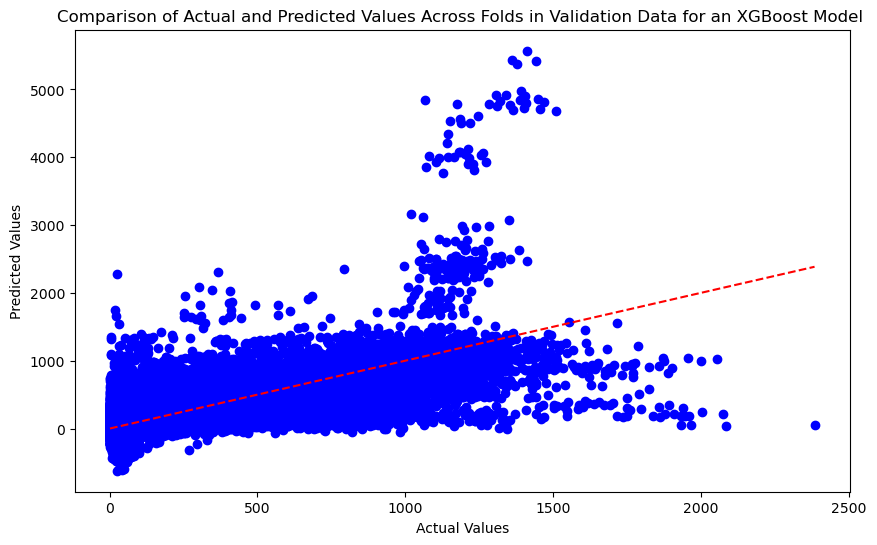

In [9]:
# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(all_actual, all_predicted, c='blue')
plt.plot([min(all_actual), max(all_actual)], [min(all_actual), max(all_actual)], '--', c='red')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Comparison of Actual and Predicted Values Across Folds in Validation Data for an XGBoost Model ')
plt.show()

In [14]:
# Save to file
with open('XGBoost_model.pkl', 'wb') as model_file:
    pickle.dump(xgboostmodel, model_file)

# Testing the XGboost Model

In [16]:
# Making predictions
y_test_pred = xgboostmodel.predict(X_test)

# Calculating the RMSE
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
# Calculate R^2 for validation and test sets
r2_test_xgboost = r2_score(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
rmse_test,r2_test_xgboost,mae

(37.564541996775795, 0.7133398240299884, 19.098817721392177)

In [20]:
# Get feature importances
feature_importances = xgboostmodel.feature_importances_
feature_importances

array([1.5786190e-02, 2.1425122e-02, 9.3040494e-03, 9.9114161e-03,
       3.5149127e-03, 1.7827854e-01, 4.4919555e-03, 2.8010266e-02,
       4.5909005e-01, 6.5769819e-03, 3.6393488e-03, 4.4133257e-02,
       6.7560800e-04, 6.0672801e-02, 4.4044736e-03, 2.9647243e-03,
       1.3641960e-02, 9.0260506e-03, 4.2032371e-03, 5.9103202e-03,
       7.1005407e-03, 4.0895716e-04, 1.0969234e-02, 1.0954473e-02,
       5.2431863e-02, 0.0000000e+00, 1.6603423e-02, 6.6095591e-03,
       0.0000000e+00, 0.0000000e+00, 9.2606116e-03], dtype=float32)

In [1]:
# Plotting the actual vs predicted values
plt.figure(figsize=(7, 5))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values for Test Set using the XGBoost Model')
plt.savefig('./Actual vs Predicted Values for Test Set using the XGBoost Model.png',  bbox_inches='tight',dpi=300)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', c='red')
plt.show()

NameError: name 'plt' is not defined

In [23]:
# Assuming the first column of train_data is the timestamp column
timestamps = test_data[:, 0]

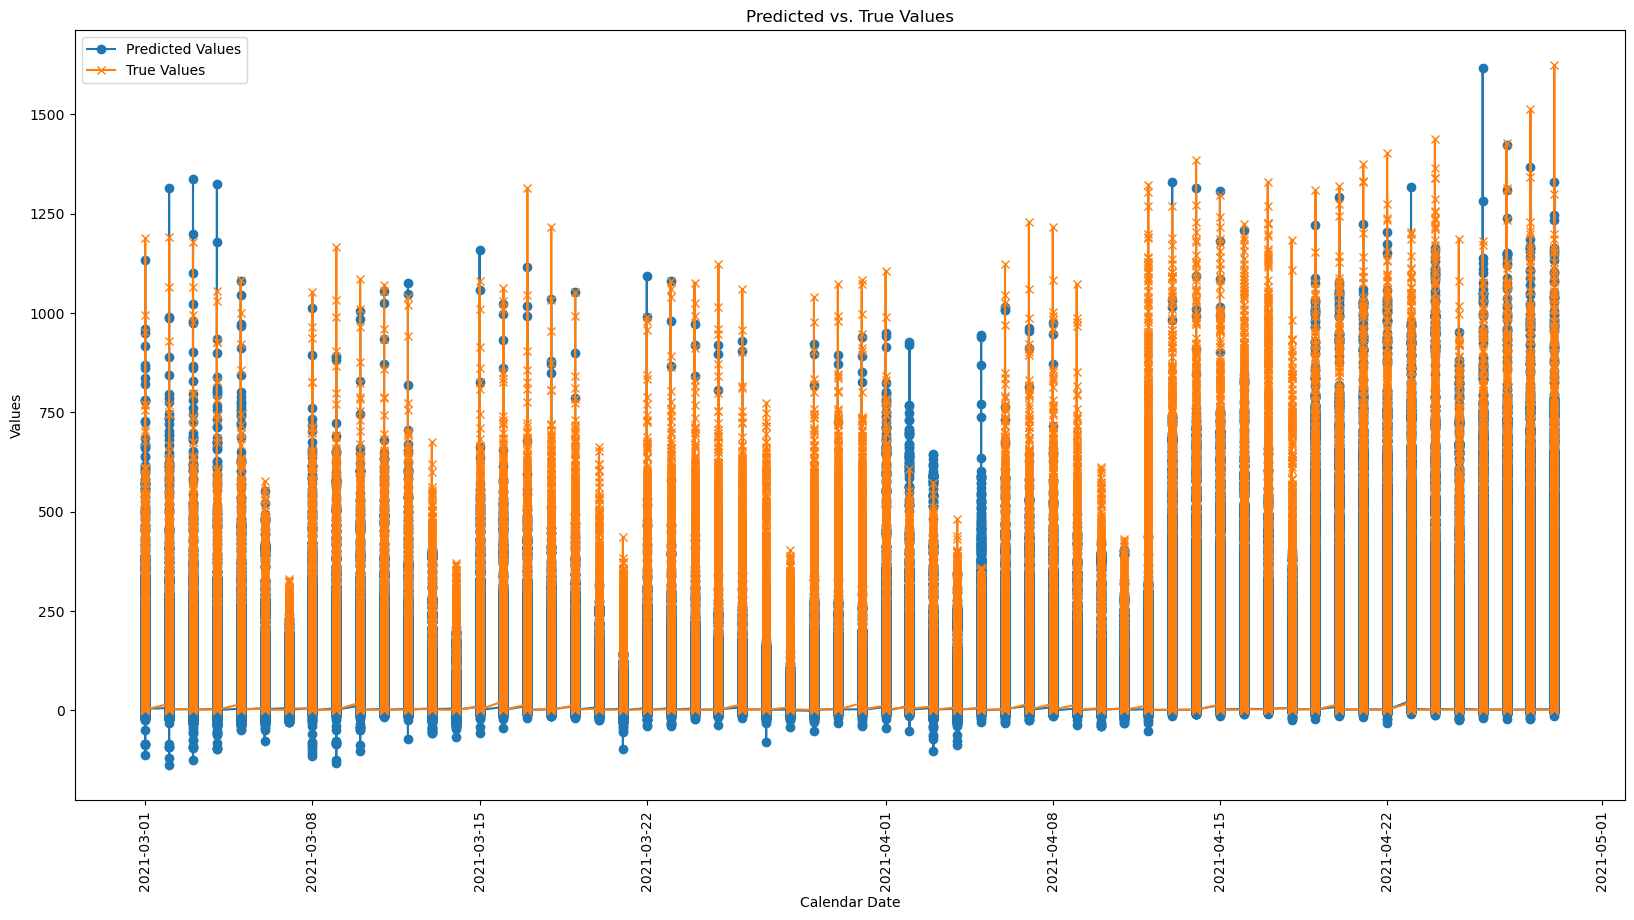

In [33]:
plt.figure(figsize=(20, 10))
plt.plot(timestamps, y_test_pred, label='Predicted Values', marker='o')
plt.plot(timestamps, y_test, label='True Values', marker='x')
plt.xlabel('Calendar Date')
plt.ylabel('Values')
plt.title('Predicted vs. True Values')
plt.legend()
plt.xticks(rotation=90)
plt.savefig('./Predictionvs true labels for xgboost model.png',  bbox_inches='tight')
plt.show()

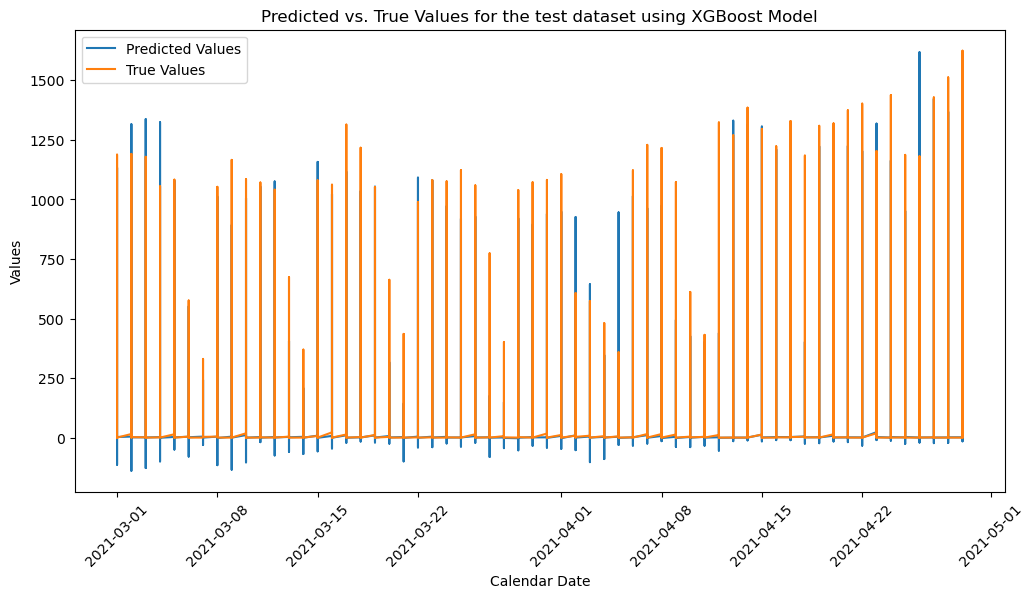

In [35]:
# Create a plot for predicted vs. true values based on CALENDARDATE
plt.figure(figsize=(12, 6))
plt.plot(timestamps, y_test_pred, label='Predicted Values')
plt.plot(timestamps, y_test, label='True Values')
plt.xlabel('Calendar Date')
plt.ylabel('Values')
plt.title('Predicted vs. True Values for the test dataset using XGBoost Model')
plt.legend()
plt.xticks(rotation=45)
plt.savefig('./Predictionvs true labels for xgboost model2.png',  bbox_inches='tight')
plt.show()

# Random Forest Regressor Model

In [11]:
# Initialize RandomForestClassifier
model = RandomForestRegressor(criterion ='squared_error',max_depth=9)

In [12]:
    # Initialize TimeSeriesSplit
    # Number of splits: 5
    # Training window size: 20 observations
    # Test window size: 5 observations (this is the default)
    tscv = TimeSeriesSplit(n_splits=5)

    # Initialize RMSE list to store RMSE values for each fold
    rmse_list = []
    r2_list = []
    mae_list = []
    # Initialize lists to store actual and predicted values across all folds
    all_actual = []
    all_predicted = []
    # Counter for fold number
    fold=0
    # Perform Rolling-Window Cross-Validation
    for train_index, test_index in tscv.split(X):

        # Get training and test sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index],y[test_index]

        # Train the model on the training data
        model.fit(X_train, y_train)

        # Make predictions on the test data
        y_pred = model.predict(X_test)

        # Store actual and predicted values for this fold
        all_actual.extend(y_test)
        all_predicted.extend(y_pred)

        # Calculate RMSE (Root Mean Squared Error) for the current fold
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        rmse_list.append(rmse)
        # Calculate R2 (R-squared) for the current fold
        r2 = r2_score(y_test, y_pred)
        r2_list.append(r2)
        # Calculate MAE for the current fold
        mae = mean_absolute_error(y_test, y_pred)
        mae_list.append(mae)

        print(f"Evaluation for fold {fold}")
        print(f"MAE for the current fold: {mae}")
        print(f"RMSE for the current fold: {rmse}")
        print(f"R2 for the current fold: {r2}")
        fold+=1
    # Calculate average RMSE and R2 across all folds
    average_rmse = np.mean(rmse_list)
    print(f"Average RMSE: {average_rmse}")
    average_r2 = np.mean(r2_list)
    print(f"Average R2: {average_r2}")
    average_mae = np.mean(mae_list)
    print(f"Average MAE: {average_mae}")

Evaluation for fold 0
MAE for the current fold: 8.155751620535277
RMSE for the current fold: 17.176404740094952
R2 for the current fold: 0.5239450387915374
Evaluation for fold 1
MAE for the current fold: 10.796182918405254
RMSE for the current fold: 21.625029767518605
R2 for the current fold: 0.8843704937097555
Evaluation for fold 2
MAE for the current fold: 12.913823529093134
RMSE for the current fold: 24.20826298844957
R2 for the current fold: 0.9287393983456633
Evaluation for fold 3
MAE for the current fold: 17.979429247393345
RMSE for the current fold: 39.97773190973256
R2 for the current fold: 0.7452459388287507
Evaluation for fold 4
MAE for the current fold: 15.996814403194582
RMSE for the current fold: 31.435729235390884
R2 for the current fold: 0.4415789447574121
Average RMSE: 26.884631728237316
Average R2: 0.7047759628866237
Average MAE: 13.168400343724318


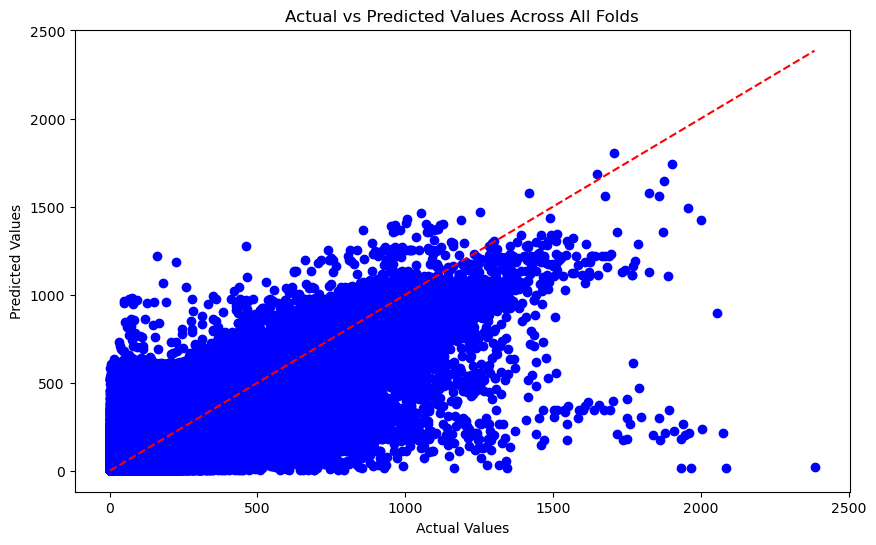

In [15]:
# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(all_actual, all_predicted, c='blue')
plt.plot([min(all_actual), max(all_actual)], [min(all_actual), max(all_actual)], '--', c='red')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values Across All Folds Random forest')
plt.show()

In [13]:
import pickle

# Save to file
with open('random_forest_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

In [16]:
# Dropping the 'N' column to get the feature matrix
X_test = np.delete(test_data,0 , axis=1)
# Extracting the target variable 'N'
y_test = X_test[:, 2]
# Dropping the 'N' column to get the feature matrix
X_test = np.delete(X_test,2 , axis=1)
X_test

array([[1, 0, 3.0, ..., 1, 0, 1],
       [1, 0, 3.0, ..., 1, 0, 1],
       [1, 1, 3.0, ..., 1, 0, 1],
       ...,
       [4, 1, 4.0, ..., 2, 0, 5],
       [4, 1, 4.0, ..., 2, 0, 5],
       [4, 1, 4.0, ..., 2, 0, 5]], dtype=object)

In [17]:
y_test

array([1, 13, 2, ..., 3, 3, 1], dtype=object)

In [70]:
# Load the model from the .pkl file
with open('./random_forest_model.pkl', 'rb') as file:
    random_forest_model = pickle.load(file)

In [71]:
# Making predictions
y_test_pred = random_forest_model.predict(X_test)

# Calculating the RMSE
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
# Calculate R^2 for validation and test sets
r2_test_xgboost = r2_score(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
rmse_test,r2_test_xgboost,mae

(40.3534598802339, 0.6691945007976683, 19.78849845080786)

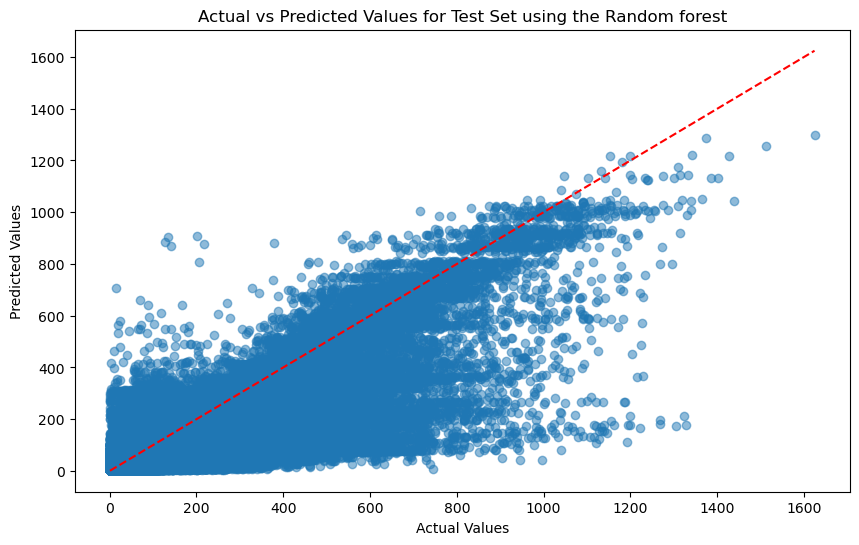

In [72]:
# Plotting the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values for Test Set using the Random forest')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', c='red')
plt.savefig('./Predictionvs true labels for randomforest model on test dataset.png',  bbox_inches='tight')
plt.show()

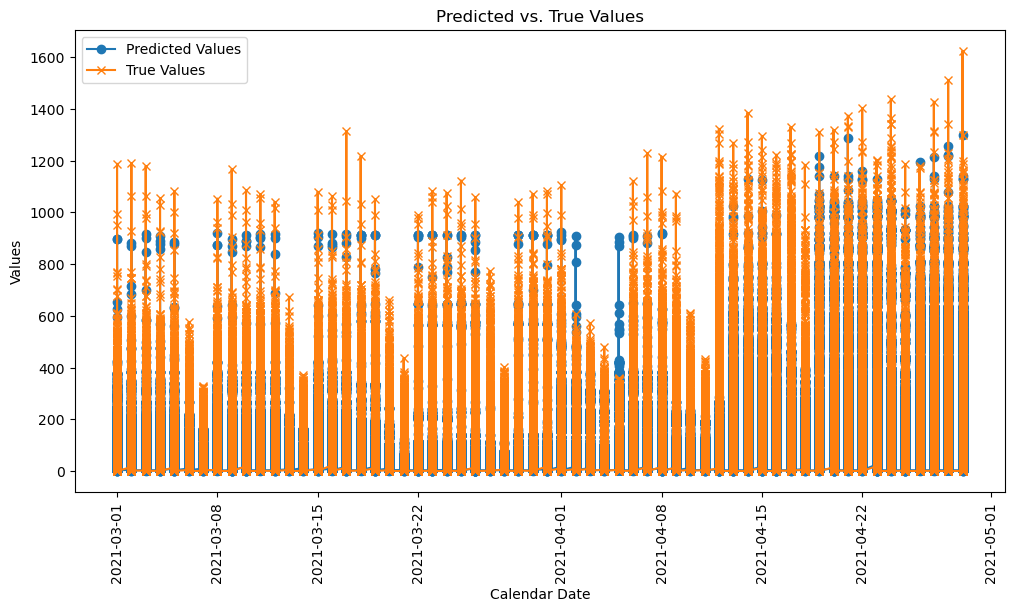

In [75]:
plt.figure(figsize=(12,6))
plt.plot(timestamps, y_test_pred, label='Predicted Values', marker='o')
plt.plot(timestamps, y_test, label='True Values', marker='x')
plt.xlabel('Calendar Date')
plt.ylabel('Values')
plt.title('Predicted vs. True Values')
plt.legend()
plt.xticks(rotation=90)
plt.savefig('./Predictionvs true labels for Random forest model calenderdate.png',  bbox_inches='tight')
plt.show()

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Test,16.4022,2175.3989,46.6412,0.8318,0.5931,0.9563


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

#evaluating

#linearmodel

In [12]:
linear_model = SGDRegressor(penalty=None,loss='squared_error',alpha=0.01,verbose=0)

In [13]:
    # Initialize TimeSeriesSplit
    # Number of splits: 5
    # Training window size: 20 observations
    # Test window size: 5 observations (this is the default)
    tscv = TimeSeriesSplit(n_splits=5)

    # Initialize RMSE list to store RMSE values for each fold
    rmse_list = []
    r2_list = []
    mae_list = []
    # Initialize lists to store actual and predicted values across all folds
    all_actual = []
    all_predicted = []
    # Counter for fold number
    fold=0
    # Perform Rolling-Window Cross-Validation
    for train_index, test_index in tscv.split(X):

        # Get training and test sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index],y[test_index]

        # Train the model on the training data
        linear_model.fit(X_train, y_train)

        # Make predictions on the test data
        y_pred = linear_model.predict(X_test)

        # Store actual and predicted values for this fold
        all_actual.extend(y_test)
        all_predicted.extend(y_pred)

        # Calculate RMSE (Root Mean Squared Error) for the current fold
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        rmse_list.append(rmse)
        # Calculate R2 (R-squared) for the current fold
        r2 = r2_score(y_test, y_pred)
        r2_list.append(r2)
        # Calculate MAE for the current fold
        mae = mean_absolute_error(y_test, y_pred)
        mae_list.append(mae)

        print(f"Evaluation for fold {fold}")
        print(f"MAE for the current fold: {mae}")
        print(f"RMSE for the current fold: {rmse}")
        print(f"R2 for the current fold: {r2}")
        fold+=1
    # Calculate average RMSE and R2 across all folds
    average_rmse = np.mean(rmse_list)
    print(f"Average RMSE: {average_rmse}")
    average_r2 = np.mean(r2_list)
    print(f"Average R2: {average_r2}")
    average_mae = np.mean(mae_list)
    print(f"Average MAE: {average_mae}")

Evaluation for fold 0
MAE for the current fold: 2394254862584.9727
RMSE for the current fold: 5626581336645.33
R2 for the current fold: -5.108363202735657e+22
Evaluation for fold 1
MAE for the current fold: 16807006566644.502
RMSE for the current fold: 19569479522711.047
R2 for the current fold: -9.469210995015044e+22
Evaluation for fold 2
MAE for the current fold: 14725895530712.086
RMSE for the current fold: 18339872852457.703
R2 for the current fold: -4.089920519047035e+22
Evaluation for fold 3
MAE for the current fold: 4041775857966.3286
RMSE for the current fold: 5424065545074.314
R2 for the current fold: -4.6895878013256493e+21
Evaluation for fold 4
MAE for the current fold: 18594107065257.8
RMSE for the current fold: 20936639613037.02
R2 for the current fold: -2.4770151403527172e+23
Average RMSE: 13979327773985.082
Average R2: -8.781320980091495e+22
Average MAE: 11312607976633.137


In [14]:
# Save to file
with open('linear_model.pkl', 'wb') as model_file:
    pickle.dump(linear_model, model_file)

In [21]:
# Calculate R^2 for validation and test sets
r2_valid_sgd = r2_score(y_valid, y_valid_pred_sgd)
r2_test_sgd = r2_score(y_test, y_test_pred_sgd)

r2_valid_sgd, r2_test_sgd

(-0.6289382190091675, -0.6183879140274382)

In [ ]:
# tube_df = pd.read_csv(str(parent_path)+'/20200101_20210429_TUBE.csv')
# lockdown_df = pd.read_csv(str(parent_path)+'/LOCKDOWN_PHASES.csv')
# NLC_STATIONNAME_df = pd.read_csv(str(parent_path)+'/NLC_STATIONNAME.csv')
# period_df  = pd.read_csv(str(parent_path)+'/PERIOD.csv')
# restrictionsweekly_df = pd.read_csv(str(parent_path)+'/restrictions_weekly.csv')
xy_df  = pd.read_csv(str(parent_path)+'/XY.csv')

In [ ]:
tube_df.head()

,CALENDARDATE,DOW,NLC,SUBSYSTEM,HOUR,ENTRYEXIT,N
0,01/01/2020,WED,500,LU,4.50,Entry,18
1,01/01/2020,WED,500,LU,4.50,Exit,11
2,01/01/2020,WED,500,LU,4.75,Entry,18
3,01/01/2020,WED,500,LU,4.75,Exit,17
4,01/01/2020,WED,500,LU,5.00,Entry,27


In [ ]:
tube_df.describe(include='all')

,CALENDARDATE,DOW,NLC,SUBSYSTEM,HOUR,ENTRYEXIT,N
count,18680332,18680332,1.868033e+07,18680332,1.868033e+07,18680332,1.868033e+07
unique,486,7,NaN,1,NaN,2,NaN
top,25/01/2020,FRI,NaN,LU,NaN,Exit,NaN
freq,47517,2765649,NaN,18680332,NaN,9364514,NaN
mean,NaN,NaN,6.679336e+02,NaN,1.483342e+01,NaN,5.987402e+01
std,NaN,NaN,3.940863e+02,NaN,5.620062e+00,NaN,1.350674e+02
min,NaN,NaN,5.000000e+02,NaN,3.500000e+00,NaN,1.000000e+00
25%,NaN,NaN,5.740000e+02,NaN,1.000000e+01,NaN,8.000000e+00
50%,NaN,NaN,6.410000e+02,NaN,1.475000e+01,NaN,2.200000e+01
75%,NaN,NaN,7.160000e+02,NaN,1.950000e+01,NaN,5.900000e+01


In [ ]:
# change the format of date column
tube_df['CALENDARDATE'] = pd.to_datetime(
    tube_df['CALENDARDATE'].apply(lambda x: x.replace('/','-')),
    format='%d-%m-%Y'
    )
# Create a mapping dictionary
mapping = {'MON': 1, 'TUE': 2, 'WED': 3, 'THU': 4, 'FRI': 5, 'SAT': 6, 'SUN': 7}
mapping_entry_exit={'Entry':0,'Exit':1}

# Replace categorical values with numerical values
tube_df['DOW'] = tube_df['DOW'].replace(mapping)

tube_df['ENTRYEXIT'] = tube_df['ENTRYEXIT'].replace(mapping_entry_exit)
tube_df.head(3)

,CALENDARDATE,DOW,NLC,SUBSYSTEM,HOUR,ENTRYEXIT,N
0,2020-01-01,3,500,LU,4.50,0,18
1,2020-01-01,3,500,LU,4.50,1,11
2,2020-01-01,3,500,LU,4.75,0,18


In [ ]:
tube_df.dtypes

CALENDARDATE    datetime64[ns]
DOW                      int64
NLC                      int64
SUBSYSTEM               object
HOUR                   float64
ENTRYEXIT                int64
N                        int64
dtype: object

In [ ]:
lockdown_df['CALENDARDATE'] = pd.to_datetime(
    lockdown_df['CALENDARDATE'].apply(lambda x: x.replace('/','-')),
    format='%d-%m-%Y'
    )
lockdown_df.head(3)

,CALENDARDATE,LOCKDOWN_NATIONAL,LOCKDOWN_REGIONAL,SHOPS_CLOSED,PUBS_CLOSED,SCHOOLS_CLOSED
0,2020-02-02,0,0,0,0,0
1,2020-02-03,0,0,0,0,0
2,2020-02-04,0,0,0,0,0


In [ ]:
lockdown_df.tail()

,CALENDARDATE,LOCKDOWN_NATIONAL,LOCKDOWN_REGIONAL,SHOPS_CLOSED,PUBS_CLOSED,SCHOOLS_CLOSED
448,2021-04-25,0,0,0,0,0
449,2021-04-26,0,0,0,0,0
450,2021-04-27,0,0,0,0,0
451,2021-04-28,0,0,0,0,0
452,2021-04-29,0,0,0,0,0


In [ ]:
lockdown_df.dtypes

CALENDARDATE         datetime64[ns]
LOCKDOWN_NATIONAL            object
LOCKDOWN_REGIONAL             int64
SHOPS_CLOSED                  int64
PUBS_CLOSED                   int64
SCHOOLS_CLOSED                int64
dtype: object

In [ ]:
lockdown_df['LOCKDOWN_REGIONAL'].value_counts()

0        246
1        173
Tier4     16
Tier2     14
Tier3      4
Name: LOCKDOWN_REGIONAL, dtype: int64

In [ ]:
# Create a mapping dictionary
mapping = {'0': 0, '1': 1, 'Tier4': 4, 'Tier2': 2, 'Tier3': 3}

# Replace categorical values with numerical values
lockdown_df['LOCKDOWN_REGIONAL'] = lockdown_df['LOCKDOWN_REGIONAL'].replace(mapping)

In [ ]:
lockdown_df['LOCKDOWN_REGIONAL'].value_counts()

0    51
1    27
2    14
3     3
Name: LOCKDOWN_REGIONAL, dtype: int64

In [ ]:
lockdown_df.describe(include='all')

,CALENDARDATE,LOCKDOWN_NATIONAL,LOCKDOWN_REGIONAL,SHOPS_CLOSED,PUBS_CLOSED,SCHOOLS_CLOSED
count,453,453.0,453,453.000000,453.000000,453.000000
unique,453,2.0,5,NaN,NaN,NaN
top,2020-02-02 00:00:00,0.0,0,NaN,NaN,NaN
freq,1,280.0,246,NaN,NaN,NaN
first,2020-02-02 00:00:00,NaN,NaN,NaN,NaN,NaN
last,2021-04-29 00:00:00,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,0.496689,0.558499,0.293598
std,NaN,NaN,NaN,0.500542,0.497115,0.455914
min,NaN,NaN,NaN,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,0.000000,0.000000,0.000000


In [ ]:
NLC_STATIONNAME_df.head()

,NLC,STATIONNAME,MODE,BOROUGH,STATIONTYPE,NAPTAN
0,500,Acton Town,LU,Ealing,Outer Suburb,940GZZLUACT
1,502,Aldgate,LU,City of London,City,940GZZLUALD
2,503,Aldgate East,LU,Tower Hamlets,City,940GZZLUADE
3,505,Alperton,LU,Brent,Outer Suburb,940GZZLUALP
4,506,Amersham,LU,Buckinghamshire,Outer Suburb,940GZZLUAMS


In [ ]:
NLC_STATIONNAME_df.describe(include='all')

,NLC,STATIONNAME,MODE,BOROUGH,STATIONTYPE,NAPTAN
count,271.000000,271,271,271,271,271
unique,NaN,270,1,30,7,264
top,NaN,Stratford,LU,City of Westminster,Outer Suburb,940GZZLUKSX
freq,NaN,2,271,31,131,3
mean,667.597786,NaN,NaN,NaN,NaN,NaN
std,392.914048,NaN,NaN,NaN,NaN,NaN
min,500.000000,NaN,NaN,NaN,NaN,NaN
25%,573.000000,NaN,NaN,NaN,NaN,NaN
50%,642.000000,NaN,NaN,NaN,NaN,NaN
75%,715.500000,NaN,NaN,NaN,NaN,NaN


In [ ]:
period_df.rename(columns={'QHR': 'HOUR'}, inplace=True)
period_df.tail(9)

,HOUR,PERIOD
95,28.25,NT2 (0100-0400)
96,28.50,NT2 (0100-0400)
97,28.75,NT2 (0100-0400)
98,29.00,NT2 (0100-0400)
99,29.25,NT2 (0100-0400)
100,29.50,NT2 (0100-0400)
101,29.75,NT2 (0100-0400)
102,30.00,NT2 (0100-0400)
103,30.25,NT2 (0100-0400)


In [ ]:
period_df['HOUR'].unique()

array([ 4.5 ,  4.75,  5.  ,  5.25,  5.5 ,  5.75,  6.  ,  6.25,  6.5 ,
        6.75,  7.  ,  7.25,  7.5 ,  7.75,  8.  ,  8.25,  8.5 ,  8.75,
        9.  ,  9.25,  9.5 ,  9.75, 10.  , 10.25, 10.5 , 10.75, 11.  ,
       11.25, 11.5 , 11.75, 12.  , 12.25, 12.5 , 12.75, 13.  , 13.25,
       13.5 , 13.75, 14.  , 14.25, 14.5 , 14.75, 15.  , 15.25, 15.5 ,
       15.75, 16.  , 16.25, 16.5 , 16.75, 17.  , 17.25, 17.5 , 17.75,
       18.  , 18.25, 18.5 , 18.75, 19.  , 19.25, 19.5 , 19.75, 20.  ,
       20.25, 20.5 , 20.75, 21.  , 21.25, 21.5 , 21.75, 22.  , 22.25,
       22.5 , 22.75, 23.  , 23.25, 23.5 , 23.75, 24.  , 24.25, 24.5 ,
       24.75, 25.  , 25.25, 25.5 , 25.75, 26.  , 26.25, 26.5 , 26.75,
       27.  , 27.25, 27.5 , 27.75, 28.  , 28.25, 28.5 , 28.75, 29.  ,
       29.25, 29.5 , 29.75, 30.  , 30.25])

In [ ]:
restrictionsweekly_df.head(2)

,week_start,schools_closed,pubs_closed,shops_closed,eating_places_closed,stay_at_home,household_mixing_indoors_banned,wfh,rule_of_6_indoors,curfew,eat_out_to_help_out
0,2020-03-02,0,0,0,0,0,0,0,0,0,0
1,2020-03-09,0,0,0,0,0,0,0,0,0,0


In [ ]:
xy_df.drop(['X','Y'],axis=1,inplace=True)
xy_df.head(3)

,NLC,CODE,ZONE,LAT,LONG
0,500,ACT,3.0,51.5028,-0.2802
1,501,BAR,1.0,51.5202,-0.0977
2,502,ALD,1.0,51.5143,-0.0756


In [ ]:
xy_df.ZONE.value_counts()

1.0    64
2.0    58
4.0    44
3.0    40
5.0    22
6.0    19
2.5    10
3.5     6
7.0     4
1.5     4
9.0     2
8.0     1
6.5     1
5.5     1
Name: ZONE, dtype: int64

## Considering sample data from **2020-09-15 to 2020-10-19**

In [ ]:
start_date = pd.to_datetime('2020-09-15')
end_date = pd.to_datetime('2020-12-19')

lockdown_df = lockdown_df.loc[(lockdown_df['CALENDARDATE'] >= start_date)
                     & (lockdown_df['CALENDARDATE'] < end_date)]

tube_df_sub = tube_df.loc[(tube_df['CALENDARDATE'] >= start_date)
                     & (tube_df['CALENDARDATE'] < end_date)]

In [ ]:
tube_df_sub.head()

,CALENDARDATE,DOW,NLC,SUBSYSTEM,HOUR,ENTRYEXIT,N
9653496,2020-09-15,2,500,LU,4.50,1,1
9653497,2020-09-15,2,500,LU,4.75,0,11
9653498,2020-09-15,2,500,LU,4.75,1,1
9653499,2020-09-15,2,500,LU,5.00,0,11
9653500,2020-09-15,2,500,LU,5.25,0,16


In [ ]:
def week_of_month(dt):
    """ Returns the week of the month for the specified date.
    """
    first_day = dt.replace(day=1)

    dom = dt.day
    adjusted_dom = dom + first_day.weekday()

    return int(ceil(adjusted_dom/7.0))

def extract_days(df):
  df['year'] = pd.DatetimeIndex(df['CALENDARDATE']).year
  df['month'] = pd.DatetimeIndex(df['CALENDARDATE']).month
  # day of week- 0 = monday and 6=sunday
  df['day_of_week'] = pd.DatetimeIndex(df['CALENDARDATE']).dayofweek
  # is it a weekend
  df['is_weekend'] = [1 if (x == 5) or (x==6)  else 0 for x in df['day_of_week']]
  # which week of the Year
  df['week'] = pd.DatetimeIndex(df['CALENDARDATE']).week
  # which week of the Month
  df['week_month'] = [week_of_month(i) for i in list(df['CALENDARDATE'])]
  return df

In [ ]:
# delete additional dataframes for memory issues
del tube_df

In [ ]:
# merge the Dataframes
# merge 1 - Merge of NLC for the latitude and longitude- Features
tube_location = tube_df_sub.merge(xy_df, on='NLC', how='left')
# Merge -2 -  Merge On calender Date of tube daily data with Lockdown data
tube_location_lockdown = tube_location.merge(lockdown_df, on='CALENDARDATE', how='inner')
# merge -3 - merge on station name
tube_location_lockdown_name = tube_location_lockdown.merge(NLC_STATIONNAME_df, on='NLC', how='left')
# merge on the time of tap based on period
tube_location_lockdown_name = tube_location_lockdown_name.merge(period_df, on='HOUR', how='left')
#extracting date features
tube_location_lockdown_name  = extract_days(tube_location_lockdown_name)

In [ ]:
tube_location_lockdown_name.head()

,CALENDARDATE,DOW,NLC,SUBSYSTEM,HOUR,ENTRYEXIT,N,CODE,ZONE,LAT,...,BOROUGH,STATIONTYPE,NAPTAN,PERIOD,year,month,day_of_week,is_weekend,week,week_month
0,2020-09-15,2,500,LU,4.50,1,1,ACT,3.0,51.5028,...,Ealing,Outer Suburb,940GZZLUACT,EM (0400-0700),2020,9,1,0,38,3
1,2020-09-15,2,500,LU,4.75,0,11,ACT,3.0,51.5028,...,Ealing,Outer Suburb,940GZZLUACT,EM (0400-0700),2020,9,1,0,38,3
2,2020-09-15,2,500,LU,4.75,1,1,ACT,3.0,51.5028,...,Ealing,Outer Suburb,940GZZLUACT,EM (0400-0700),2020,9,1,0,38,3
3,2020-09-15,2,500,LU,5.00,0,11,ACT,3.0,51.5028,...,Ealing,Outer Suburb,940GZZLUACT,EM (0400-0700),2020,9,1,0,38,3
4,2020-09-15,2,500,LU,5.25,0,16,ACT,3.0,51.5028,...,Ealing,Outer Suburb,940GZZLUACT,EM (0400-0700),2020,9,1,0,38,3


Step 1: Create time_order DataFrame

In this step, the 'HOUR' and 'PERIOD' columns are grouped by 'HOUR'. For each unique 'HOUR', the code finds the set of 'PERIOD' values and selects the first element. The resulting DataFrame contains the unique 'HOUR' values along with their associated 'PERIOD' values.

Step 2: Calculate list_1

In this step, the DataFrame from Step 1 is used again. It groups the DataFrame by 'PERIOD' and ranks the 'HOUR' values in ascending order using the 'first' method. The resulting ranks are calculated based on the order in which the 'HOUR' values appear within each 'PERIOD' group.

Step 3: Assign ranks to time_order['rank']

In this step, the ranks from Step 2 are assigned to the 'rank' column of the time_order DataFrame.

Step 4: Display the first two rows of time_order


In [ ]:
# create a Dataframe which has time and its associated PERIOD
time_order  = tube_location_lockdown_name[['HOUR','PERIOD']].groupby('HOUR').agg({
    'PERIOD':lambda x: list(set(x))[0]
    }).reset_index()

# create a partition for the Period and rank them by the HOUR
list_1 = list(tube_location_lockdown_name[['HOUR','PERIOD']].groupby('HOUR').agg({
'PERIOD':lambda x: list(set(x))[0]
}).reset_index().groupby("PERIOD")["HOUR"].rank(method="first", ascending=True))

# all the hour's for each partition are ranked by the HOUR
time_order['rank'] = list_1

time_order.head(2)

,HOUR,PERIOD,rank
0,3.50,NaN,NaN
1,3.75,NaN,NaN


In [ ]:
time_order.head(5)

,HOUR,PERIOD,rank
0,3.50,NaN,NaN
1,3.75,NaN,NaN
2,4.00,NaN,NaN
3,4.25,NaN,NaN
4,4.50,EM (0400-0700),1.0


In [ ]:
tube_location_lockdown_name = tube_location_lockdown_name.merge(time_order, on='HOUR', how='left')

In [ ]:
tube_location_lockdown_name.columns

Index(['CALENDARDATE', 'DOW', 'NLC', 'SUBSYSTEM', 'HOUR', 'ENTRYEXIT', 'N',
       'CODE', 'ZONE', 'LAT', 'LONG', 'LOCKDOWN_NATIONAL', 'LOCKDOWN_REGIONAL',
       'SHOPS_CLOSED', 'PUBS_CLOSED', 'SCHOOLS_CLOSED', 'STATIONNAME', 'MODE',
       'BOROUGH', 'STATIONTYPE', 'NAPTAN', 'PERIOD_x', 'year', 'month',
       'day_of_week', 'is_weekend', 'week', 'week_month', 'PERIOD_y', 'rank'],
      dtype='object')

In [ ]:
tube_location_lockdown_name.head(2)

,CALENDARDATE,DOW,NLC,SUBSYSTEM,HOUR,ENTRYEXIT,N,CODE,ZONE,LAT,...,NAPTAN,PERIOD_x,year,month,day_of_week,is_weekend,week,week_month,PERIOD_y,rank
0,2020-09-15,2,500,LU,4.50,1,1,ACT,3.0,51.5028,...,940GZZLUACT,EM (0400-0700),2020,9,1,0,38,3,EM (0400-0700),1.0
1,2020-09-15,2,500,LU,4.75,0,11,ACT,3.0,51.5028,...,940GZZLUACT,EM (0400-0700),2020,9,1,0,38,3,EM (0400-0700),2.0


# Data Analysis

**Correlation between features**

In [ ]:
tube_location_lockdown_name[['NAPTAN','STATIONNAME']].apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)

,NAPTAN,STATIONNAME
NAPTAN,1.000000,0.987537
STATIONNAME,0.987537,1.000000


In [ ]:
print('NAPTAN=',len(set(tube_location_lockdown_name['NAPTAN'])),'STATIONNAME=',len(set(tube_location_lockdown_name['STATIONNAME'])),
'CODE=',len(set(tube_location_lockdown_name['CODE'])),'NLC=',len(set(tube_location_lockdown_name['NLC'])))

NAPTAN= 264 STATIONNAME= 269 CODE= 263 NLC= 270


In [ ]:
tube_location_lockdown_name[['CODE','STATIONNAME']].apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)

,CODE,STATIONNAME
CODE,1.000000,0.982745
STATIONNAME,0.982745,1.000000


In [ ]:
tube_location_lockdown_name.drop(['NAPTAN','SUBSYSTEM','CODE','MODE','DOW','CALENDARDATE',"NLC","HOUR"],axis=1,inplace=True)

In [ ]:
tube_location_lockdown_name.drop(['PERIOD_y'],axis=1,inplace=True)
tube_location_lockdown_name.rename(columns={"PERIOD_x": "period"},inplace=True)

In [ ]:
tube_location_lockdown_name.head(2)

,ENTRYEXIT,N,ZONE,LAT,LONG,LOCKDOWN_NATIONAL,LOCKDOWN_REGIONAL,SHOPS_CLOSED,PUBS_CLOSED,SCHOOLS_CLOSED,...,BOROUGH,STATIONTYPE,period,year,month,day_of_week,is_weekend,week,week_month,rank
0,1,1,3.0,51.5028,-0.2802,0,0,0,0,0,...,Ealing,Outer Suburb,EM (0400-0700),2020,9,1,0,38,3,1.0
1,0,11,3.0,51.5028,-0.2802,0,0,0,0,0,...,Ealing,Outer Suburb,EM (0400-0700),2020,9,1,0,38,3,2.0


In [ ]:
tube_location_lockdown_name.tail(2)

,ENTRYEXIT,N,ZONE,LAT,LONG,LOCKDOWN_NATIONAL,LOCKDOWN_REGIONAL,SHOPS_CLOSED,PUBS_CLOSED,SCHOOLS_CLOSED,...,BOROUGH,STATIONTYPE,period,year,month,day_of_week,is_weekend,week,week_month,rank
3841985,1,4,3.0,51.5414,-0.0032,0,3,0,0,0,...,Newham,Shopping,NT1 (2200-0100),2020,12,4,0,51,3,9.0
3841986,0,1,3.0,51.5414,-0.0032,0,3,0,0,0,...,Newham,Shopping,NT1 (2200-0100),2020,12,4,0,51,3,12.0


In [ ]:
tube_location_lockdown_name = tube_location_lockdown_name[[
    'ZONE', 'LAT', 'LONG',
    'STATIONNAME', 'BOROUGH', 'STATIONTYPE',
    'year', 'month', 'day_of_week', 'is_weekend', 'week', 'week_month',
    'rank','period','ENTRYEXIT','N'
]]
df_city = tube_location_lockdown_name[['STATIONNAME','LAT','LONG','STATIONTYPE','ZONE','BOROUGH']].groupby('STATIONNAME').agg({
    'LAT': lambda x: list(set(x))[0] ,
    'LONG' : lambda x: list(set(x))[0],
    'STATIONTYPE': lambda x: list(set(x))[0],
    'ZONE' : lambda x: list(set(x))[0],
    'BOROUGH' : lambda x: list(set(x))[0]
    }).reset_index()

In [ ]:
tube_location_lockdown_name.head(2)

,ZONE,LAT,LONG,STATIONNAME,BOROUGH,STATIONTYPE,year,month,day_of_week,is_weekend,week,week_month,rank,period,ENTRYEXIT,N
0,3.0,51.5028,-0.2802,Acton Town,Ealing,Outer Suburb,2020,9,1,0,38,3,1.0,EM (0400-0700),1,1
1,3.0,51.5028,-0.2802,Acton Town,Ealing,Outer Suburb,2020,9,1,0,38,3,2.0,EM (0400-0700),0,11


In [ ]:
# tube_location_lockdown_name.to_csv('required_data.csv')

In [ ]:
tube_location_lockdown_name=pd.read_csv('required_data.csv',header='infer')

In [ ]:
# tube_location_lockdown_name.dtypes

In [ ]:
df_X  = tube_location_lockdown_name.drop(['N'],axis=1)
enc = OneHotEncoder()
encoder = enc.fit(df_X)
train_X = encoder.transform(df_X)
train_y = list(tube_location_lockdown_name['N'])
test_X = encoder.transform(df_X[:1000])
test_y = list(tube_location_lockdown_name[:1000]['N'])
pickle.dump(encoder,open('encoding.pkl','wb'))
sklearn_model = SGDRegressor(penalty=None,loss='squared_error',alpha=0,max_iter=10000,verbose=0)
sklearn_model.fit(train_X, train_y)
Y_predicted=sklearn_model.predict(test_X)
sklearn_model_MSE=mean_squared_error(Y_predicted,test_y)
print('Test Loss',sklearn_model_MSE)
Y_predicted_train=sklearn_model.predict(train_X)
sklearn_model_MSE=mean_squared_error(Y_predicted_train,train_y)
print('Train Loss',sklearn_model_MSE)

Test Loss 838.6928086144358
Train Loss 3714.8873770012824


In [ ]:
tube_location_lockdown_name['STATIONNAME'] = tube_location_lockdown_name['STATIONNAME'].astype('category')
tube_location_lockdown_name['BOROUGH'] = tube_location_lockdown_name['BOROUGH'].astype('category')
tube_location_lockdown_name['STATIONTYPE'] = tube_location_lockdown_name['STATIONTYPE'].astype('category')
tube_location_lockdown_name['period'] = tube_location_lockdown_name['period'].astype('category')

In [ ]:
tube_location_lockdown_name['STATIONNAME']=tube_location_lockdown_name['STATIONNAME'].cat.codes

In [ ]:
tube_location_lockdown_name['BOROUGH']=tube_location_lockdown_name['BOROUGH'].cat.codes
tube_location_lockdown_name['STATIONTYPE']=tube_location_lockdown_name['STATIONTYPE'].cat.codes
tube_location_lockdown_name['period']=tube_location_lockdown_name['period'].cat.codes

In [ ]:
tube_location_lockdown_name.head(2)

,Unnamed: 0,ZONE,LAT,LONG,STATIONNAME,BOROUGH,STATIONTYPE,year,month,day_of_week,is_weekend,week,week_month,rank,period,ENTRYEXIT,N
0,0,3.0,51.5028,-0.2802,0,7,3,2020,9,1,0,38,3,1.0,1,1,1
1,1,3.0,51.5028,-0.2802,0,7,3,2020,9,1,0,38,3,2.0,1,0,11


In [ ]:
tube_location_lockdown_name.dtypes

Unnamed: 0       int64
ZONE           float64
LAT            float64
LONG           float64
STATIONNAME      int16
BOROUGH           int8
STATIONTYPE       int8
year             int64
month            int64
day_of_week      int64
is_weekend       int64
week             int64
week_month       int64
rank           float64
period            int8
ENTRYEXIT        int64
N                int64
dtype: object

In [ ]:
tube_location_lockdown_name.isnull().any()

Unnamed: 0     False
ZONE           False
LAT            False
LONG           False
STATIONNAME    False
BOROUGH        False
STATIONTYPE    False
year           False
month          False
day_of_week    False
is_weekend     False
week           False
week_month     False
rank            True
period         False
ENTRYEXIT      False
N              False
dtype: bool

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


# # Perform one-hot encoding for categorical variables
# data_encoded = pd.get_dummies(tube_location_lockdown_name, columns=['STATIONNAME', 'BOROUGH', 'STATIONTYPE', 'period'])

# Prepare the input variables (X) and target variable (y)
X = tube_location_lockdown_name.drop('N', axis=1)  # Input variables (all columns except 'N')
y = tube_location_lockdown_name['N']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an instance of the LinearRegression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict the target variable for the testing data
predictions = model.predict(X_test)

# Calculate the mean squared error (MSE)
mse = mean_squared_error(y_test, predictions)

# Print the MSE
print("Mean Squared Error:", mse)

ValueError: ignored

In [ ]:
data_encoded

,ZONE,LAT,LONG,year,month,day_of_week,is_weekend,week,week_month,rank,...,STATIONTYPE_Terminus,STATIONTYPE_Tourist,period_AM (0700-1000),period_EM (0400-0700),period_EV (1900-2200),period_IP1 (1000-1300),period_IP2 (1300-1600),period_NT1 (2200-0100),period_NT2 (0100-0400),period_PM (1600-1900)
0,3.0,51.5028,-0.2802,2020,9,1,0,38,3,1.0,...,0,0,0,1,0,0,0,0,0,0
1,3.0,51.5028,-0.2802,2020,9,1,0,38,3,2.0,...,0,0,0,1,0,0,0,0,0,0
2,3.0,51.5028,-0.2802,2020,9,1,0,38,3,2.0,...,0,0,0,1,0,0,0,0,0,0
3,3.0,51.5028,-0.2802,2020,9,1,0,38,3,3.0,...,0,0,0,1,0,0,0,0,0,0
4,3.0,51.5028,-0.2802,2020,9,1,0,38,3,4.0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3841982,3.0,51.5414,-0.0032,2020,12,4,0,51,3,7.0,...,0,0,0,0,0,0,0,1,0,0
3841983,3.0,51.5414,-0.0032,2020,12,4,0,51,3,8.0,...,0,0,0,0,0,0,0,1,0,0
3841984,3.0,51.5414,-0.0032,2020,12,4,0,51,3,8.0,...,0,0,0,0,0,0,0,1,0,0
3841985,3.0,51.5414,-0.0032,2020,12,4,0,51,3,9.0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
tube_location_lockdown_name.dtypes

ZONE           float64
LAT            float64
LONG           float64
STATIONNAME     object
BOROUGH         object
STATIONTYPE     object
year             int64
month            int64
day_of_week      int64
is_weekend       int64
week             int64
week_month       int64
rank           float64
period          object
ENTRYEXIT        int64
N                int64
dtype: object

In [ ]:
tube_location_lockdown_name['STATIONNAME'] = tube_location_lockdown_name['STATIONNAME'].astype('category')
tube_location_lockdown_name['BOROUGH'] = tube_location_lockdown_name['BOROUGH'].astype('category')
tube_location_lockdown_name['STATIONTYPE'] = tube_location_lockdown_name['STATIONTYPE'].astype('category')
tube_location_lockdown_name['period'] = tube_location_lockdown_name['period'].astype('category')

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error
import pickle

# Convert data to PyTorch tensors
train_X_tensor = torch.Tensor(train_X.toarray())
train_y_tensor = torch.Tensor(train_y)
test_X_tensor = torch.Tensor(test_X.toarray())
test_y_tensor = torch.Tensor(test_y)

# Define the neural network model
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc = nn.Linear(input_size, 1)

    def forward(self, x):
        x = self.fc(x)
        return x

# Create an instance of the model
input_size = train_X_tensor.shape[1]
model = Net(input_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Convert the data into DataLoader for batch processing
batch_size = 32
train_dataset = TensorDataset(train_X_tensor, train_y_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y.view(-1, 1))
        loss.backward()
        optimizer.step()

# Save the trained model
torch.save(model.state_dict(), 'trained_model.pth')

# Load the saved model
model = Net(input_size)
model.load_state_dict(torch.load('trained_model.pth'))

# Evaluate the model
with torch.no_grad():
    model.eval()
    test_outputs = model(test_X_tensor)
    test_loss = criterion(test_outputs, test_y_tensor.view(-1, 1))

print('Test Loss:', test_loss.item())

NameError: ignored

#dask


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import dask.datafrem=